In [1]:
import os
import re
import time

import pickle

from copy import deepcopy

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

from skmultiflow.trees import RegressionHoeffdingTree

In [2]:
project_path = os.path.dirname(os.path.abspath("__file__"))
input_path = project_path
data_path = project_path

# Data configuration

![./imgs/data_description_1.png](./imgs/data_description_1.png)
![./imgs/data_description_3.png](./imgs/data_description_2.png)
![./imgs/data_description_2.png](./imgs/data_description_3.png)

* For supervised learning

    * Labeled data: moldset_labeled.csv

    * Algorithms
    
        * SVM
        * RF
        * DNN
        * AE (Denosing AutoEncoder)

* For semi-supervised learning

    * Unlabeled data: unlabeled_data.csv
    
    * Algorithms
       
       * PCA
       * AE
       * SVDD (Deep SVDD)
    
       In baseline, 
    
       * SVM
       * NN
       
    Semi-superivsed learning is trained by entropy minimization and pseudo-labeling
    
    * Pseudo-labeling
    
        Pseudo-labeling is a method in which the predicted output for data without class variables using the learned model is regarded as a virtual class variable and used for future learning.

        
# Data configuration for semi-supervised learning

![./imgs/abstract_for_dataset.png](./imgs/abstract_for_dataset.png)

In [3]:
os.listdir(data_path)

['.ipynb_checkpoints',
 'aqc_bandit.yaml',
 'bandit_molding.ipynb',
 'baseline_molding.ipynb',
 'imgs',
 'moldset_labeled.csv',
 'NN_cn7.h5',
 'NN_rg3.h5',
 'README.md',
 'unlabeled_data.csv']

#  Exploratory data analysis

In [4]:
moldset_labeled = pd.read_csv(os.path.join(data_path, 'moldset_labeled.csv'), low_memory=False, index_col=0)

In [5]:
moldset_labeled

,_id,TimeStamp,PART_FACT_PLAN_DATE,PART_FACT_SERIAL,PART_NO,PART_NAME,EQUIP_CD,EQUIP_NAME,PassOrFail,Reason,...,Mold_Temperature_3,Mold_Temperature_4,Mold_Temperature_5,Mold_Temperature_6,Mold_Temperature_7,Mold_Temperature_8,Mold_Temperature_9,Mold_Temperature_10,Mold_Temperature_11,Mold_Temperature_12
0,5f8928bb9c0189cc666ef19b,2020-10-16 04:57:47,2020-10-16 오전 12:00:00,24,86141AA000,CN7 W/S SIDE MLD'G RH,S14,650톤-우진2호기,0,None,...,24.799999,27.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5f8928de9c0189cc666ef20b,2020-10-16 04:58:48,2020-10-16 오전 12:00:00,24,86141AA000,CN7 W/S SIDE MLD'G RH,S14,650톤-우진2호기,0,None,...,24.799999,27.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5f8928df9c0189cc666ef213,2020-10-16 04:58:48,2020-10-16 오전 12:00:00,23,86131AA000,CN7 W/S SIDE MLD'G LH,S14,650톤-우진2호기,0,None,...,24.799999,27.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5f8928f39c0189cc666ef25e,2020-10-16 04:59:48,2020-10-16 오전 12:00:00,23,86131AA000,CN7 W/S SIDE MLD'G LH,S14,650톤-우진2호기,0,None,...,25.000000,27.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5f8928f59c0189cc666ef265,2020-10-16 04:59:48,2020-10-16 오전 12:00:00,24,86141AA000,CN7 W/S SIDE MLD'G RH,S14,650톤-우진2호기,0,None,...,25.000000,27.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2388,5f928a009c0189cc667e9bfc,2020-10-23 07:44:00,2020-10-23 오전 12:00:00,11,86131T1000,"RG3 MOLD'G W/SHLD, LH",S14,650톤-우진2호기,0,None,...,23.700001,25.200001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2389,5f928a2c9c0189cc667e9d13,2020-10-23 07:45:02,2020-10-23 오전 12:00:00,12,86141T1000,"RG3 MOLD'G W/SHLD, RH",S14,650톤-우진2호기,0,None,...,23.600000,25.200001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2390,5f928a2d9c0189cc667e9d19,2020-10-23 07:45:02,2020-10-23 오전 12:00:00,11,86131T1000,"RG3 MOLD'G W/SHLD, LH",S14,650톤-우진2호기,0,None,...,23.600000,25.200001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2391,5f928a669c0189cc667e9e61,2020-10-23 07:46:03,2020-10-23 오전 12:00:00,12,86141T1000,"RG3 MOLD'G W/SHLD, RH",S14,650톤-우진2호기,0,None,...,23.600000,25.200001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
"ERR_FACT_QTY" in moldset_labeled.columns

False

In [7]:
moldset_labeled["EQUIP_NAME"].value_counts()

650톤-우진2호기    2607
Name: EQUIP_NAME, dtype: int64

In [8]:
moldset_labeled["PART_NO"].value_counts()

86141AA000    713
86131AA000    712
86131T1000    591
86141T1000    591
Name: PART_NO, dtype: int64

In [9]:
parts = moldset_labeled["PART_NO"].value_counts().index.tolist()

In [10]:
moldset_labeled.head()

,_id,TimeStamp,PART_FACT_PLAN_DATE,PART_FACT_SERIAL,PART_NO,PART_NAME,EQUIP_CD,EQUIP_NAME,PassOrFail,Reason,...,Mold_Temperature_3,Mold_Temperature_4,Mold_Temperature_5,Mold_Temperature_6,Mold_Temperature_7,Mold_Temperature_8,Mold_Temperature_9,Mold_Temperature_10,Mold_Temperature_11,Mold_Temperature_12
0,5f8928bb9c0189cc666ef19b,2020-10-16 04:57:47,2020-10-16 오전 12:00:00,24,86141AA000,CN7 W/S SIDE MLD'G RH,S14,650톤-우진2호기,0,None,...,24.799999,27.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5f8928de9c0189cc666ef20b,2020-10-16 04:58:48,2020-10-16 오전 12:00:00,24,86141AA000,CN7 W/S SIDE MLD'G RH,S14,650톤-우진2호기,0,None,...,24.799999,27.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5f8928df9c0189cc666ef213,2020-10-16 04:58:48,2020-10-16 오전 12:00:00,23,86131AA000,CN7 W/S SIDE MLD'G LH,S14,650톤-우진2호기,0,None,...,24.799999,27.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5f8928f39c0189cc666ef25e,2020-10-16 04:59:48,2020-10-16 오전 12:00:00,23,86131AA000,CN7 W/S SIDE MLD'G LH,S14,650톤-우진2호기,0,None,...,25.000000,27.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5f8928f59c0189cc666ef265,2020-10-16 04:59:48,2020-10-16 오전 12:00:00,24,86141AA000,CN7 W/S SIDE MLD'G RH,S14,650톤-우진2호기,0,None,...,25.000000,27.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
moldset_labeled.columns

Index(['_id', 'TimeStamp', 'PART_FACT_PLAN_DATE', 'PART_FACT_SERIAL',
       'PART_NO', 'PART_NAME', 'EQUIP_CD', 'EQUIP_NAME', 'PassOrFail',
       'Reason', 'Injection_Time', 'Filling_Time', 'Plasticizing_Time',
       'Cycle_Time', 'Clamp_Close_Time', 'Cushion_Position',
       'Switch_Over_Position', 'Plasticizing_Position', 'Clamp_Open_Position',
       'Max_Injection_Speed', 'Max_Screw_RPM', 'Average_Screw_RPM',
       'Max_Injection_Pressure', 'Max_Switch_Over_Pressure',
       'Max_Back_Pressure', 'Average_Back_Pressure', 'Barrel_Temperature_1',
       'Barrel_Temperature_2', 'Barrel_Temperature_3', 'Barrel_Temperature_4',
       'Barrel_Temperature_5', 'Barrel_Temperature_6', 'Barrel_Temperature_7',
       'Hopper_Temperature', 'Mold_Temperature_1', 'Mold_Temperature_2',
       'Mold_Temperature_3', 'Mold_Temperature_4', 'Mold_Temperature_5',
       'Mold_Temperature_6', 'Mold_Temperature_7', 'Mold_Temperature_8',
       'Mold_Temperature_9', 'Mold_Temperature_10', 'Mold_Temper

In [12]:
list_label_drop_cols = ['_id', 'TimeStamp', 'PART_FACT_PLAN_DATE', 'PART_FACT_SERIAL', 
                  'PART_NAME', 'EQUIP_CD', 'EQUIP_NAME', 'Reason', 'Mold_Temperature_1', 'Mold_Temperature_2', 
                  'Barrel_Temperature_7', 'Switch_Over_Position','Mold_Temperature_5',
                  'Mold_Temperature_6', 'Mold_Temperature_7', 'Mold_Temperature_8',
                  'Mold_Temperature_9', 'Mold_Temperature_10', 'Mold_Temperature_11','Mold_Temperature_12']

list_unlabel_drop_cols = ['_id', 'TimeStamp', 'PART_FACT_PLAN_DATE', 'PART_FACT_SERIAL', 
                  'PART_NAME', 'EQUIP_CD', 'EQUIP_NAME', 'Mold_Temperature_1', 'Mold_Temperature_2', 
                  'Barrel_Temperature_7', 'Switch_Over_Position','Mold_Temperature_5',
                  'Mold_Temperature_6', 'Mold_Temperature_7', 'Mold_Temperature_8',
                  'Mold_Temperature_9', 'Mold_Temperature_10', 'Mold_Temperature_11','Mold_Temperature_12']

In [13]:
moldset_labeled = moldset_labeled.drop(list_label_drop_cols, axis=1)

In [14]:
moldset_unlabeled = pd.read_csv(os.path.join(data_path, 'unlabeled_data.csv'), low_memory=False, index_col=0)

In [15]:
moldset_unlabeled

,_id,TimeStamp,PART_FACT_PLAN_DATE,PART_FACT_SERIAL,PART_NO,PART_NAME,EQUIP_CD,EQUIP_NAME,ERR_FACT_QTY,Injection_Time,...,Mold_Temperature_3,Mold_Temperature_4,Mold_Temperature_5,Mold_Temperature_6,Mold_Temperature_7,Mold_Temperature_8,Mold_Temperature_9,Mold_Temperature_10,Mold_Temperature_11,Mold_Temperature_12
0,5f9136166e37704af878240e,2020-01-02 00:59:22,2020-01-02 오전 12:00:00,2,87285Q5000,"SP2 CVR ROOF RACK CTR, RH",S01,1800TON-우진,11,3.18,...,0.0,0.0,0,0,0,0,0,0,0,0
1,5f9136166e37704af878240f,2020-01-02 01:01:01,2020-01-02 오전 12:00:00,1,87275Q5000,"SP2 CVR ROOF RACK CTR, LH",S01,1800TON-우진,11,16.29,...,0.0,0.0,0,0,0,0,0,0,0,0
2,5f9136166e37704af8782410,2020-01-02 01:01:01,2020-01-02 오전 12:00:00,2,87285Q5000,"SP2 CVR ROOF RACK CTR, RH",S01,1800TON-우진,11,16.29,...,0.0,0.0,0,0,0,0,0,0,0,0
3,5f9136166e37704af8782411,2020-01-02 01:02:24,2020-01-02 오전 12:00:00,1,87275Q5000,"SP2 CVR ROOF RACK CTR, LH",S01,1800TON-우진,11,16.28,...,0.0,0.0,0,0,0,0,0,0,0,0
4,5f9136166e37704af8782412,2020-01-02 01:02:24,2020-01-02 오전 12:00:00,2,87285Q5000,"SP2 CVR ROOF RACK CTR, RH",S01,1800TON-우진,11,16.28,...,0.0,0.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795310,5f926a806e37704af88455fb,2020-10-23 05:30:20,2020-10-23 오전 12:00:00,13,84721G9000,IK PNL C/PAD MAIN LHD,S10,3300TON-우진,0,12.09,...,0.0,0.0,0,0,0,0,0,0,0,0
795311,5f926a806e37704af88455fc,2020-10-23 05:30:24,2020-10-23 오전 12:00:00,10,86141S8900,LX2 W/S SIDE MLD'G RH(RHD),S12,650톤-우진,0,11.47,...,20.2,23.6,0,0,0,0,0,0,0,0
795312,5f926ab26e37704af88455fe,2020-10-23 05:31:13,2020-10-23 오전 12:00:00,1,87275Q5000,"SP2 CVR ROOF RACK CTR, LH",S01,1800TON-우진,2,16.34,...,0.0,0.0,0,0,0,0,0,0,0,0
795313,5f926ab26e37704af88455ff,2020-10-23 05:31:13,2020-10-23 오전 12:00:00,2,87285Q5000,"SP2 CVR ROOF RACK CTR, RH",S01,1800TON-우진,2,16.34,...,0.0,0.0,0,0,0,0,0,0,0,0


In [16]:
moldset_unlabeled.columns

Index(['_id', 'TimeStamp', 'PART_FACT_PLAN_DATE', 'PART_FACT_SERIAL',
       'PART_NO', 'PART_NAME', 'EQUIP_CD', 'EQUIP_NAME', 'ERR_FACT_QTY',
       'Injection_Time', 'Filling_Time', 'Plasticizing_Time', 'Cycle_Time',
       'Clamp_Close_Time', 'Cushion_Position', 'Switch_Over_Position',
       'Plasticizing_Position', 'Clamp_Open_Position', 'Max_Injection_Speed',
       'Max_Screw_RPM', 'Average_Screw_RPM', 'Max_Injection_Pressure',
       'Max_Switch_Over_Pressure', 'Max_Back_Pressure',
       'Average_Back_Pressure', 'Barrel_Temperature_1', 'Barrel_Temperature_2',
       'Barrel_Temperature_3', 'Barrel_Temperature_4', 'Barrel_Temperature_5',
       'Barrel_Temperature_6', 'Barrel_Temperature_7', 'Hopper_Temperature',
       'Mold_Temperature_1', 'Mold_Temperature_2', 'Mold_Temperature_3',
       'Mold_Temperature_4', 'Mold_Temperature_5', 'Mold_Temperature_6',
       'Mold_Temperature_7', 'Mold_Temperature_8', 'Mold_Temperature_9',
       'Mold_Temperature_10', 'Mold_Temperature_11

In [17]:
moldset_unlabeled = moldset_unlabeled.drop(list_unlabel_drop_cols, axis=1)

In [18]:
moldset_labeled_cn7 = moldset_labeled.loc[(moldset_labeled["PART_NO"] == "86131AA000") | (moldset_labeled["PART_NO"] == "86141AA000")].reset_index(drop=True).copy()
moldset_labeled_rg3 = moldset_labeled.loc[(moldset_labeled["PART_NO"] == "86131T1000") | (moldset_labeled["PART_NO"] == "86141T1000")].reset_index(drop=True).copy()

moldset_unlabeled_cn7 = moldset_unlabeled.loc[(moldset_unlabeled["PART_NO"] == "86131AA000") | (moldset_unlabeled["PART_NO"] == "86141AA000")].reset_index(drop=True).copy()
moldset_unlabeled_rg3 = moldset_unlabeled.loc[(moldset_unlabeled["PART_NO"] == "86131T1000") | (moldset_unlabeled["PART_NO"] == "86141T1000")].reset_index(drop=True).copy()

In [19]:
moldset_labeled_cn7 = moldset_labeled_cn7.drop("PART_NO", axis=1)
moldset_labeled_rg3 = moldset_labeled_rg3.drop("PART_NO", axis=1)

moldset_unlabeled_cn7 = moldset_unlabeled_cn7.drop("PART_NO", axis=1)
moldset_unlabeled_rg3 = moldset_unlabeled_rg3.drop("PART_NO", axis=1)

In [20]:
moldset_labeled_cn7

,PassOrFail,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,...,Average_Back_Pressure,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
0,0,9.59,4.47,16.920000,59.520000,7.13,653.409973,68.849998,647.98999,55.400002,...,59.299999,276.500000,274.700012,274.799988,269.200012,255.000000,229.699997,66.300003,24.799999,27.5
1,0,9.60,4.48,16.910000,59.580002,7.13,653.409973,68.839996,647.98999,55.299999,...,59.299999,276.200012,275.500000,275.299988,270.799988,254.699997,229.500000,67.199997,24.799999,27.6
2,0,9.60,4.48,16.910000,59.580002,7.13,653.409973,68.839996,647.98999,55.299999,...,59.299999,276.200012,275.500000,275.299988,270.799988,254.699997,229.500000,67.199997,24.799999,27.6
3,0,9.59,4.48,16.910000,59.560001,7.13,653.419983,68.839996,647.98999,55.299999,...,59.299999,276.500000,275.000000,275.399994,271.100006,254.899994,230.000000,66.900002,25.000000,27.6
4,0,9.59,4.48,16.910000,59.560001,7.13,653.419983,68.839996,647.98999,55.299999,...,59.299999,276.500000,275.000000,275.399994,271.100006,254.899994,230.000000,66.900002,25.000000,27.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420,0,9.62,4.51,16.790001,59.580002,7.12,653.450012,68.589996,647.98999,55.299999,...,59.700001,276.700012,276.200012,275.100006,270.399994,255.000000,230.399994,65.900002,21.600000,23.0
1421,0,9.63,4.51,16.799999,59.560001,7.12,653.450012,68.599998,647.98999,55.200001,...,59.799999,275.899994,276.000000,275.100006,271.299988,254.899994,229.600006,65.599998,21.600000,22.9
1422,0,9.63,4.51,16.799999,59.560001,7.12,653.450012,68.599998,647.98999,55.200001,...,59.799999,275.899994,276.000000,275.100006,271.299988,254.899994,229.600006,65.599998,21.600000,22.9
1423,0,9.62,4.51,16.799999,59.580002,7.12,653.450012,68.589996,647.98999,55.200001,...,59.700001,275.700012,275.000000,274.700012,271.500000,255.000000,229.800003,65.800003,21.600000,22.9


In [21]:
moldset_labeled_rg3

,PassOrFail,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,...,Average_Back_Pressure,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
0,0,1.06,0.93,13.01,61.779999,6.81,654.289978,53.560001,4.63,128.500000,...,60.299999,286.000000,285.000000,285.000000,275.399994,265.100006,234.899994,65.800003,21.600000,22.500000
1,0,1.06,0.93,13.01,61.779999,6.81,654.289978,53.560001,4.63,128.500000,...,60.299999,286.000000,285.000000,285.000000,275.399994,265.100006,234.899994,65.800003,21.600000,22.500000
2,0,1.06,0.93,12.99,61.779999,6.81,654.280029,53.580002,4.63,128.500000,...,60.500000,286.200012,285.799988,285.000000,275.600006,265.600006,234.800003,65.800003,21.500000,22.500000
3,0,1.06,0.93,12.99,61.779999,6.81,654.280029,53.580002,4.63,128.500000,...,60.500000,286.200012,285.799988,285.000000,275.600006,265.600006,234.800003,65.800003,21.500000,22.500000
4,0,1.06,0.93,12.95,61.759998,6.81,654.270020,53.560001,4.63,128.399994,...,60.200001,286.500000,285.100006,285.000000,276.000000,265.100006,234.699997,65.900002,21.500000,22.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177,0,1.06,0.94,12.87,61.759998,6.80,654.239990,53.590000,4.63,128.100006,...,61.599998,286.399994,285.200012,285.000000,276.000000,265.100006,235.300003,65.599998,23.700001,25.200001
1178,0,1.06,0.94,12.85,61.740002,6.79,654.239990,53.599998,4.63,128.000000,...,61.500000,286.700012,285.100006,285.000000,276.000000,264.700012,234.699997,65.599998,23.600000,25.200001
1179,0,1.06,0.94,12.85,61.740002,6.79,654.239990,53.599998,4.63,128.000000,...,61.500000,286.700012,285.100006,285.000000,276.000000,264.700012,234.699997,65.599998,23.600000,25.200001
1180,0,1.06,0.94,12.90,61.720001,6.80,654.250000,53.599998,4.63,128.100006,...,61.500000,285.299988,285.799988,284.799988,275.700012,265.000000,234.800003,65.500000,23.600000,25.200001


In [22]:
moldset_unlabeled_cn7

,ERR_FACT_QTY,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,...,Average_Back_Pressure,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
0,321,10.19,3.07,16.82,72.24,7.10,653.71,65.48,652.00,74.7,...,33.9,270.9,275.5,274.5,270.1,264.7,240.0,58.9,22.0,23.1
1,321,10.22,3.10,16.83,72.30,7.10,653.69,65.68,652.00,74.2,...,34.1,271.6,276.1,274.7,270.5,264.7,240.3,59.2,22.8,24.6
2,321,10.21,3.10,16.85,72.24,7.10,653.70,65.69,652.00,74.2,...,33.9,270.8,275.0,274.7,270.1,265.7,239.7,58.6,21.2,22.7
3,321,10.22,3.10,16.81,72.24,7.10,653.72,65.69,652.00,74.3,...,33.9,271.2,275.5,275.2,271.0,264.7,240.2,58.6,19.1,20.0
4,321,10.22,3.10,16.86,72.30,7.10,653.69,65.70,652.00,74.2,...,33.9,271.4,274.9,275.0,270.3,265.1,239.8,58.6,19.8,20.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52542,1,9.50,4.39,18.16,59.46,7.12,653.41,68.40,647.99,57.2,...,59.2,276.3,275.3,275.5,271.2,255.2,230.2,68.8,23.5,24.6
52543,2,9.43,4.32,19.02,59.44,7.12,653.43,68.35,647.99,58.8,...,58.6,275.8,275.7,274.7,271.8,255.1,230.0,69.5,23.5,24.5
52544,1,9.43,4.32,19.02,59.44,7.12,653.43,68.35,647.99,58.8,...,58.6,275.8,275.7,274.7,271.8,255.1,230.0,69.5,23.5,24.5
52545,2,9.36,4.24,21.10,59.36,7.12,653.45,68.12,647.99,60.5,...,57.7,276.2,275.0,275.3,271.7,254.9,230.5,69.5,23.5,24.5


In [23]:
moldset_unlabeled_rg3

,ERR_FACT_QTY,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,...,Average_Back_Pressure,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
0,135,6.00,6.00,2.90,39.10,3.4,18.70,40.50,522.50,37.9,...,0.0,0.0,264.8,269.9,270.1,260.2,239.7,60.0,0.0,0.0
1,135,6.00,6.00,2.80,39.20,3.4,18.80,40.50,522.50,40.0,...,0.0,0.0,264.8,269.9,270.1,260.1,239.6,59.9,0.0,0.0
2,135,6.00,6.00,2.90,39.20,3.4,18.70,40.50,522.60,39.5,...,0.0,0.0,264.8,270.0,270.0,260.1,239.7,59.9,0.0,0.0
3,135,6.00,6.00,2.80,39.10,3.4,18.80,40.50,522.50,40.7,...,0.0,0.0,264.8,270.1,270.0,260.0,239.8,59.9,0.0,0.0
4,135,6.00,6.00,2.80,39.10,3.4,18.80,40.50,522.50,40.9,...,0.0,0.0,264.9,270.1,270.1,259.9,240.0,59.9,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37472,0,1.06,0.94,12.93,61.78,6.8,654.24,53.59,4.63,128.0,...,61.2,286.9,284.6,285.4,274.5,266.0,234.7,64.9,23.2,24.7
37473,0,1.06,0.94,12.90,61.78,6.8,654.24,53.59,4.63,128.1,...,61.5,286.5,285.6,285.3,275.7,265.0,235.1,64.9,23.3,24.7
37474,0,1.06,0.94,12.90,61.78,6.8,654.24,53.59,4.63,128.1,...,61.5,286.5,285.6,285.3,275.7,265.0,235.1,64.9,23.3,24.7
37475,0,1.06,0.94,12.89,61.76,6.8,654.24,53.59,4.63,128.1,...,61.6,285.7,285.0,285.0,276.1,264.8,234.8,64.5,23.3,24.7


## moldset_unlabeled_cn7

In [24]:
moldset_unlabeled_cn7.describe()

,ERR_FACT_QTY,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,...,Average_Back_Pressure,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
count,52547.000000,52547.000000,52547.000000,52547.000000,52547.000000,52547.000000,52547.000000,52547.000000,52547.000000,52547.000000,...,52547.000000,52547.000000,52547.000000,52547.000000,52547.000000,52547.000000,52547.000000,52547.000000,52547.000000,52547.000000
mean,28.881211,6.424337,4.218894,10.436911,50.905432,5.141773,359.175364,52.581079,434.434858,56.389434,...,27.234318,145.529239,267.087272,268.502999,265.401555,254.059596,233.254549,57.740971,12.841428,14.730523
std,38.978939,3.020516,1.444531,7.396193,13.369645,1.868678,317.320806,13.087495,235.942618,29.437641,...,29.014509,135.601133,11.345312,10.124143,8.909881,7.613118,6.257067,10.945172,12.181921,14.162900
min,0.000000,1.000000,0.300000,0.500000,0.000000,2.800000,15.800000,32.180000,0.000000,25.100000,...,0.000000,0.000000,244.200000,231.600000,239.100000,234.400000,219.200000,34.300000,0.000000,0.000000
25%,5.000000,5.000000,3.890000,2.800000,36.600000,3.200000,17.300000,40.300000,485.900000,36.500000,...,0.000000,0.000000,264.600000,264.900000,264.800000,254.600000,229.800000,57.800000,0.000000,0.000000
50%,12.000000,5.000000,4.490000,12.810000,59.520000,5.990000,653.410000,52.660000,522.200000,49.900000,...,12.200000,245.100000,264.900000,269.900000,269.400000,255.000000,234.700000,61.600000,20.500000,22.000000
75%,34.000000,9.560000,5.000000,16.860000,63.600000,7.120000,653.560000,68.470000,647.990000,56.100000,...,59.300000,276.100000,275.400000,275.000000,270.500000,259.600000,239.900000,65.200000,23.400000,26.700000
max,321.000000,11.400000,6.000000,97.080000,119.880000,7.270000,655.330000,75.750000,652.000000,128.200000,...,112.900000,287.500000,286.200000,285.800000,279.000000,267.200000,242.800000,73.400000,38.600000,48.600000


<AxesSubplot:>

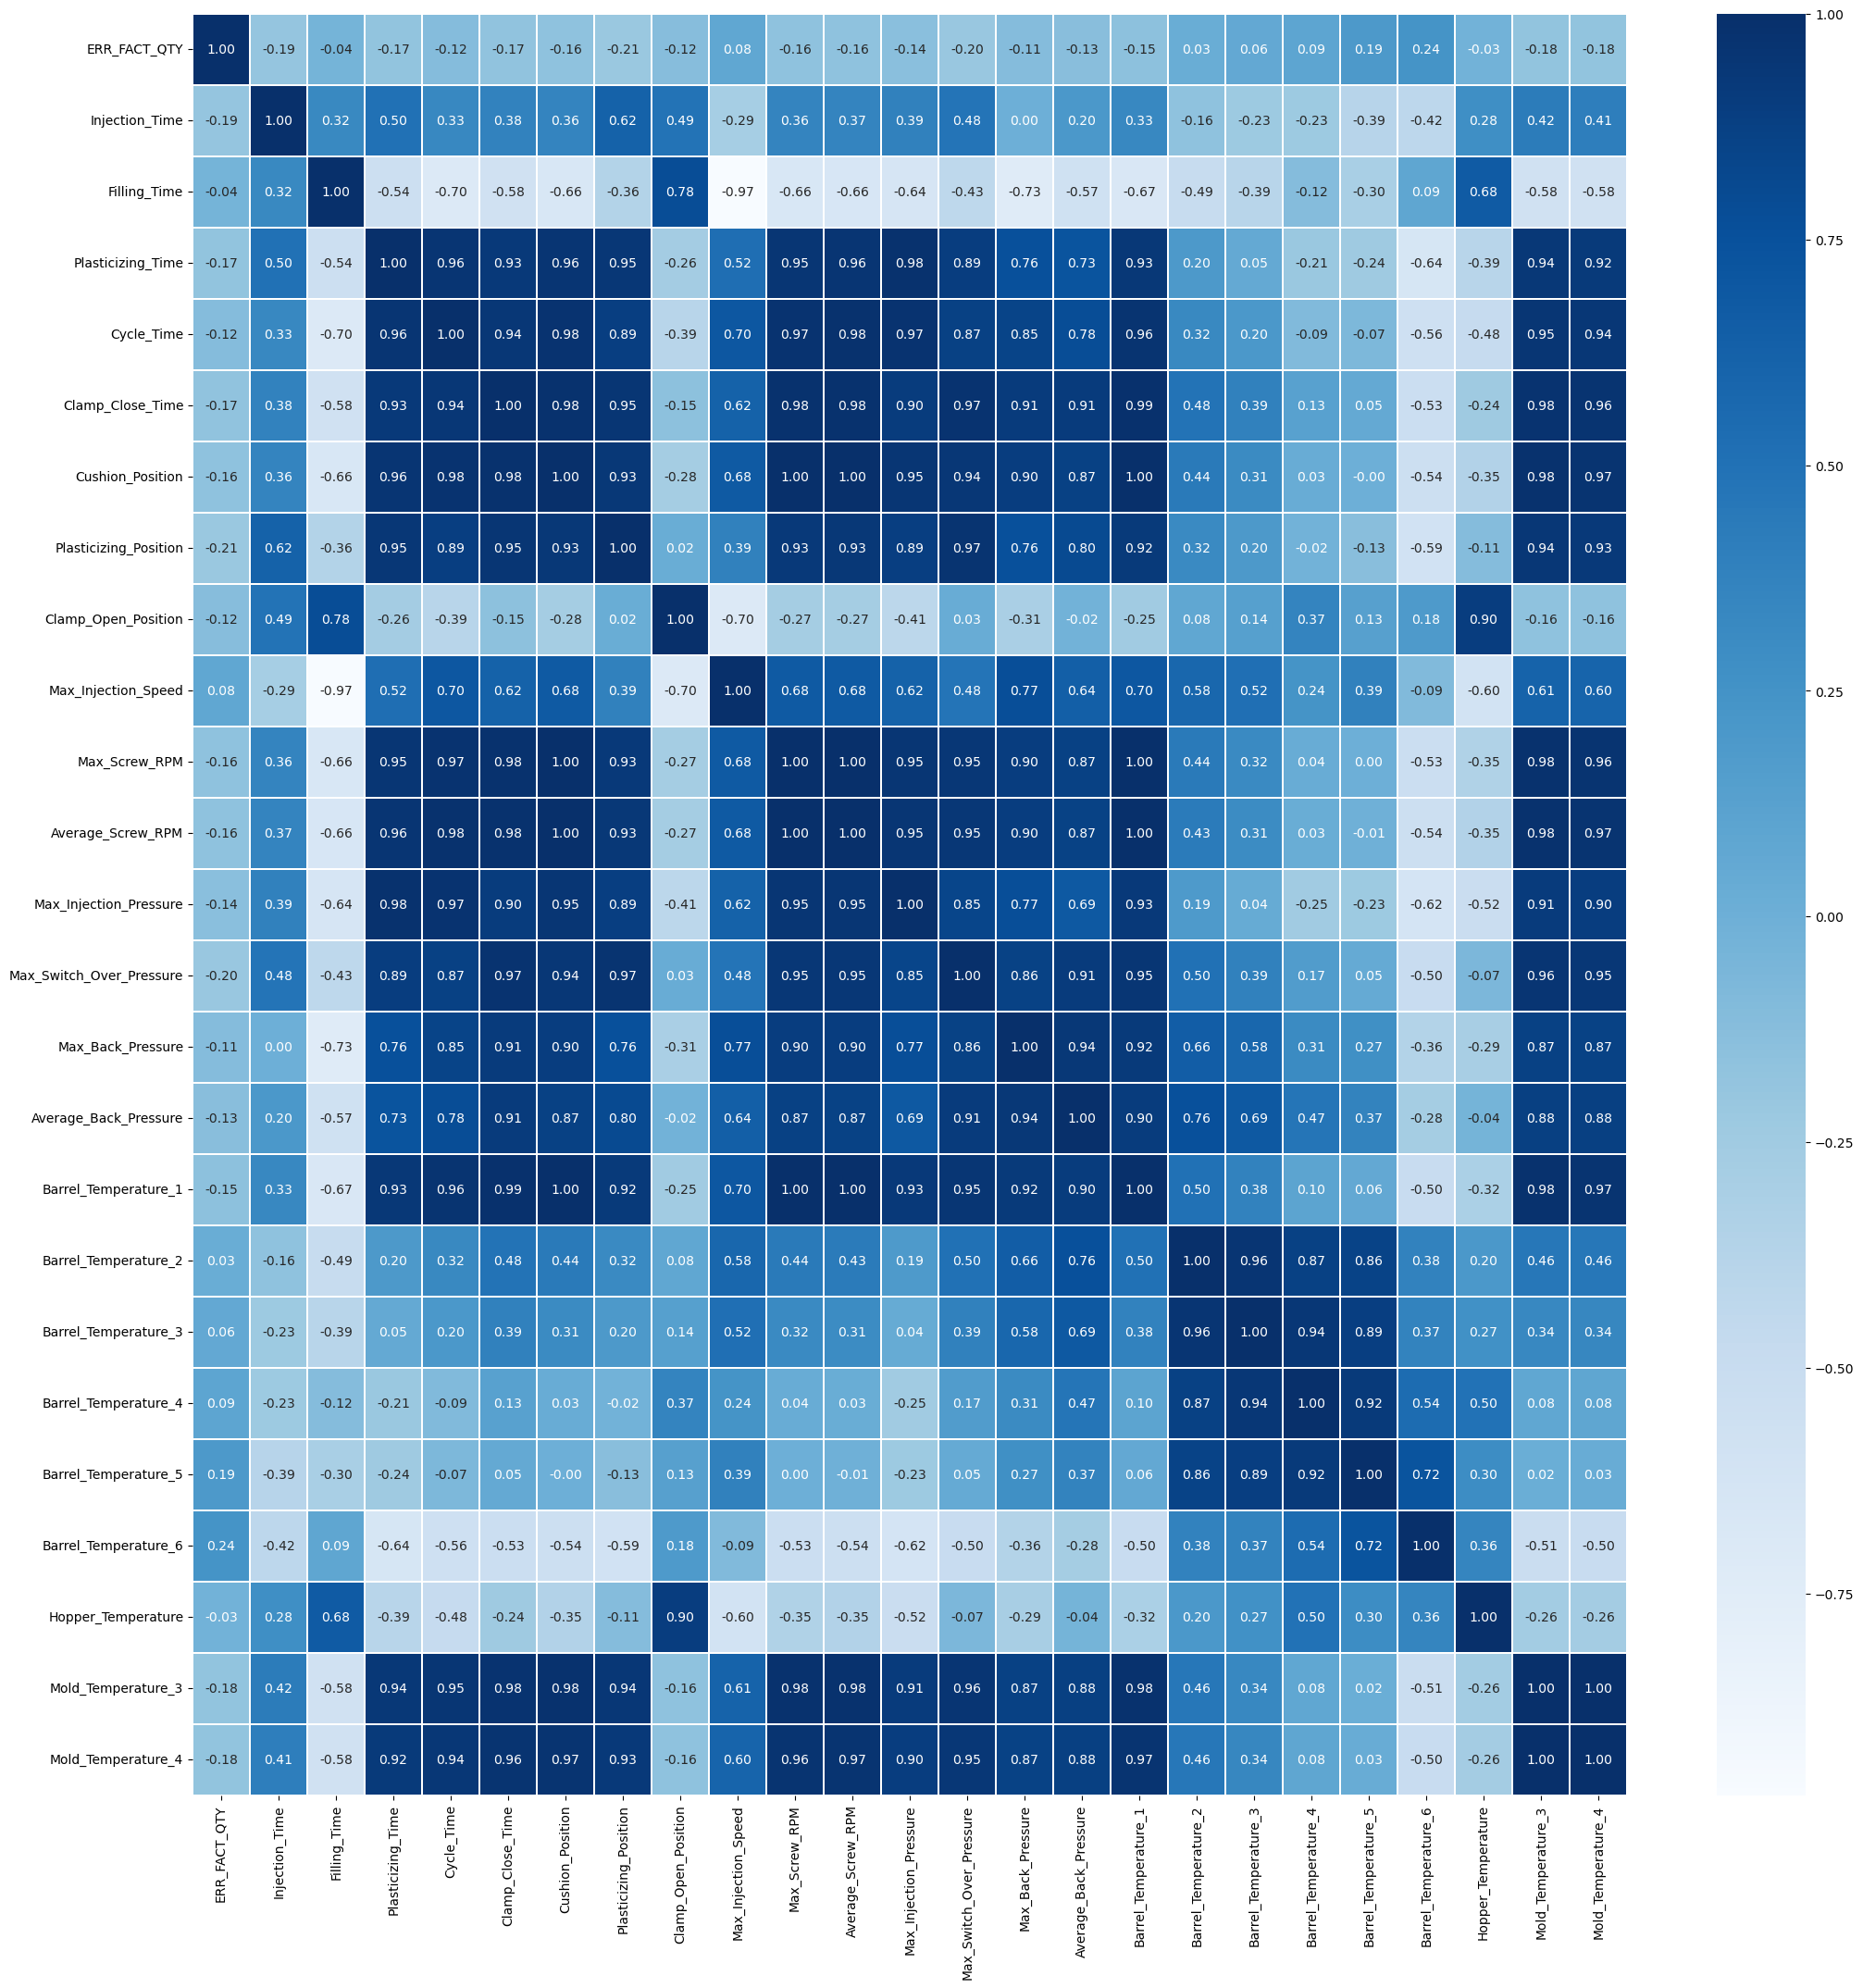

In [25]:
plt.subplots(figsize=[25,25])
sns.heatmap(data=moldset_unlabeled_cn7.corr(), linewidth=0.1,annot=True,fmt=".2f",cmap="Blues")

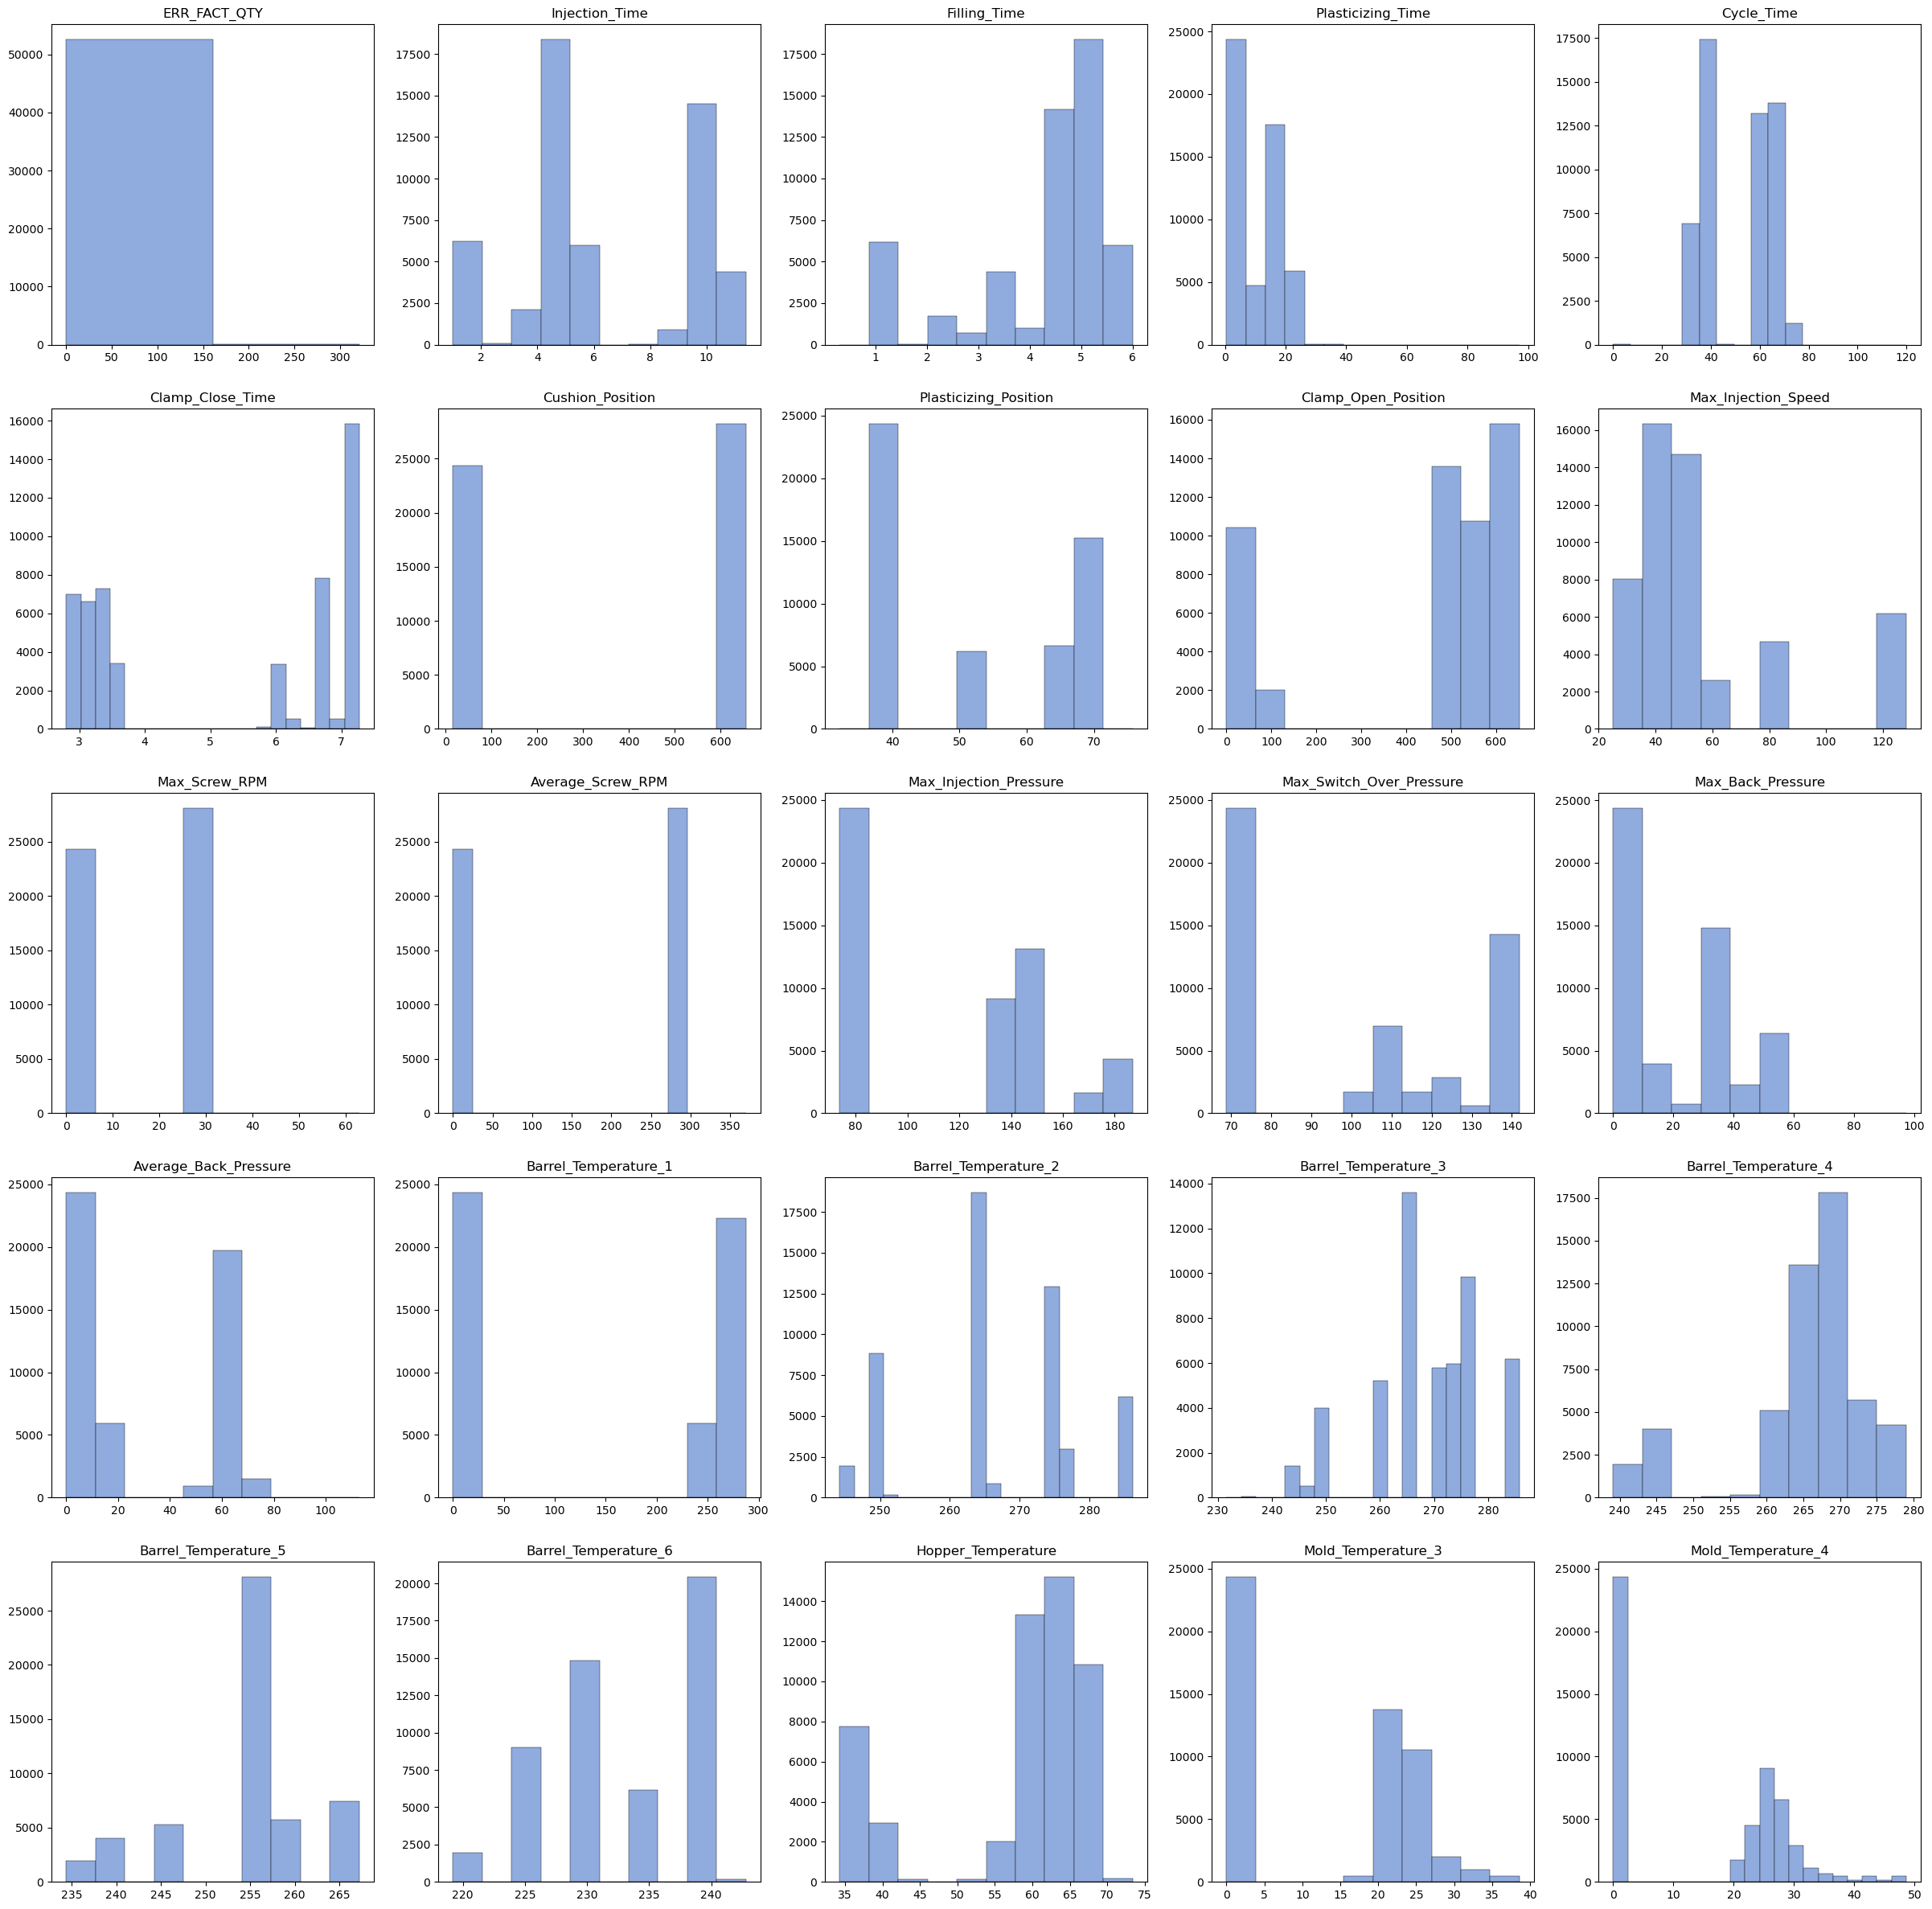

In [26]:
plt.figure(figsize=[30,30])

bins = [2,10,10,15,17,20,10,10,10,10,10,15,10,10,10,10,10,20,20,10,10,10,10,10,20,25,35,35]

for index, value in enumerate(moldset_unlabeled_cn7):
    sub = plt.subplot(5,5,index+1)
    sub.hist(moldset_unlabeled_cn7[value], bins=bins[index], facecolor=(144/255,171/255,221/255), linewidth=.3, edgecolor="black")
    plt.title(value)

## moldset_unlabeled_rg3

In [27]:
moldset_unlabeled_rg3.describe()

,ERR_FACT_QTY,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,...,Average_Back_Pressure,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
count,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000,...,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000
mean,44.417029,3.515335,2.778947,9.631108,53.469702,5.357147,405.104732,48.223423,209.289599,86.657328,...,36.580767,169.379563,273.179625,274.535830,269.174136,259.571657,235.694215,58.029599,14.053569,15.813630
std,67.320817,2.837536,2.087176,6.238300,12.758191,1.633415,310.466273,7.846830,243.368693,41.854656,...,33.234145,136.544147,12.796782,12.004843,9.526382,8.061772,4.830513,9.782343,11.607758,13.580681
min,0.000000,0.130000,0.000000,0.400000,0.000000,2.800000,0.000000,33.350000,0.000000,0.000000,...,0.000000,0.000000,244.200000,234.400000,239.100000,234.400000,219.500000,33.200000,0.000000,0.000000
25%,3.000000,1.050000,0.930000,2.900000,38.900000,3.400000,18.700000,40.500000,4.630000,39.900000,...,0.000000,0.000000,264.800000,269.900000,269.800000,259.800000,234.800000,58.000000,0.000000,0.000000
50%,13.000000,2.630000,1.650000,12.800000,61.760000,6.640000,654.250000,52.540000,35.630000,79.500000,...,58.200000,246.000000,265.400000,270.100000,270.200000,260.300000,235.100000,61.300000,20.500000,22.000000
75%,55.000000,5.000000,5.000000,13.030000,63.600000,6.740000,654.280000,53.570000,522.100000,127.500000,...,60.800000,286.000000,285.100000,285.000000,275.200000,265.000000,239.900000,64.100000,22.400000,24.000000
max,353.000000,11.390000,6.000000,38.710000,76.190000,15.100000,655.160000,72.760000,654.990000,128.800000,...,136.000000,287.600000,286.700000,286.000000,278.100000,266.900000,241.000000,71.200000,34.800000,45.900000


<AxesSubplot:>

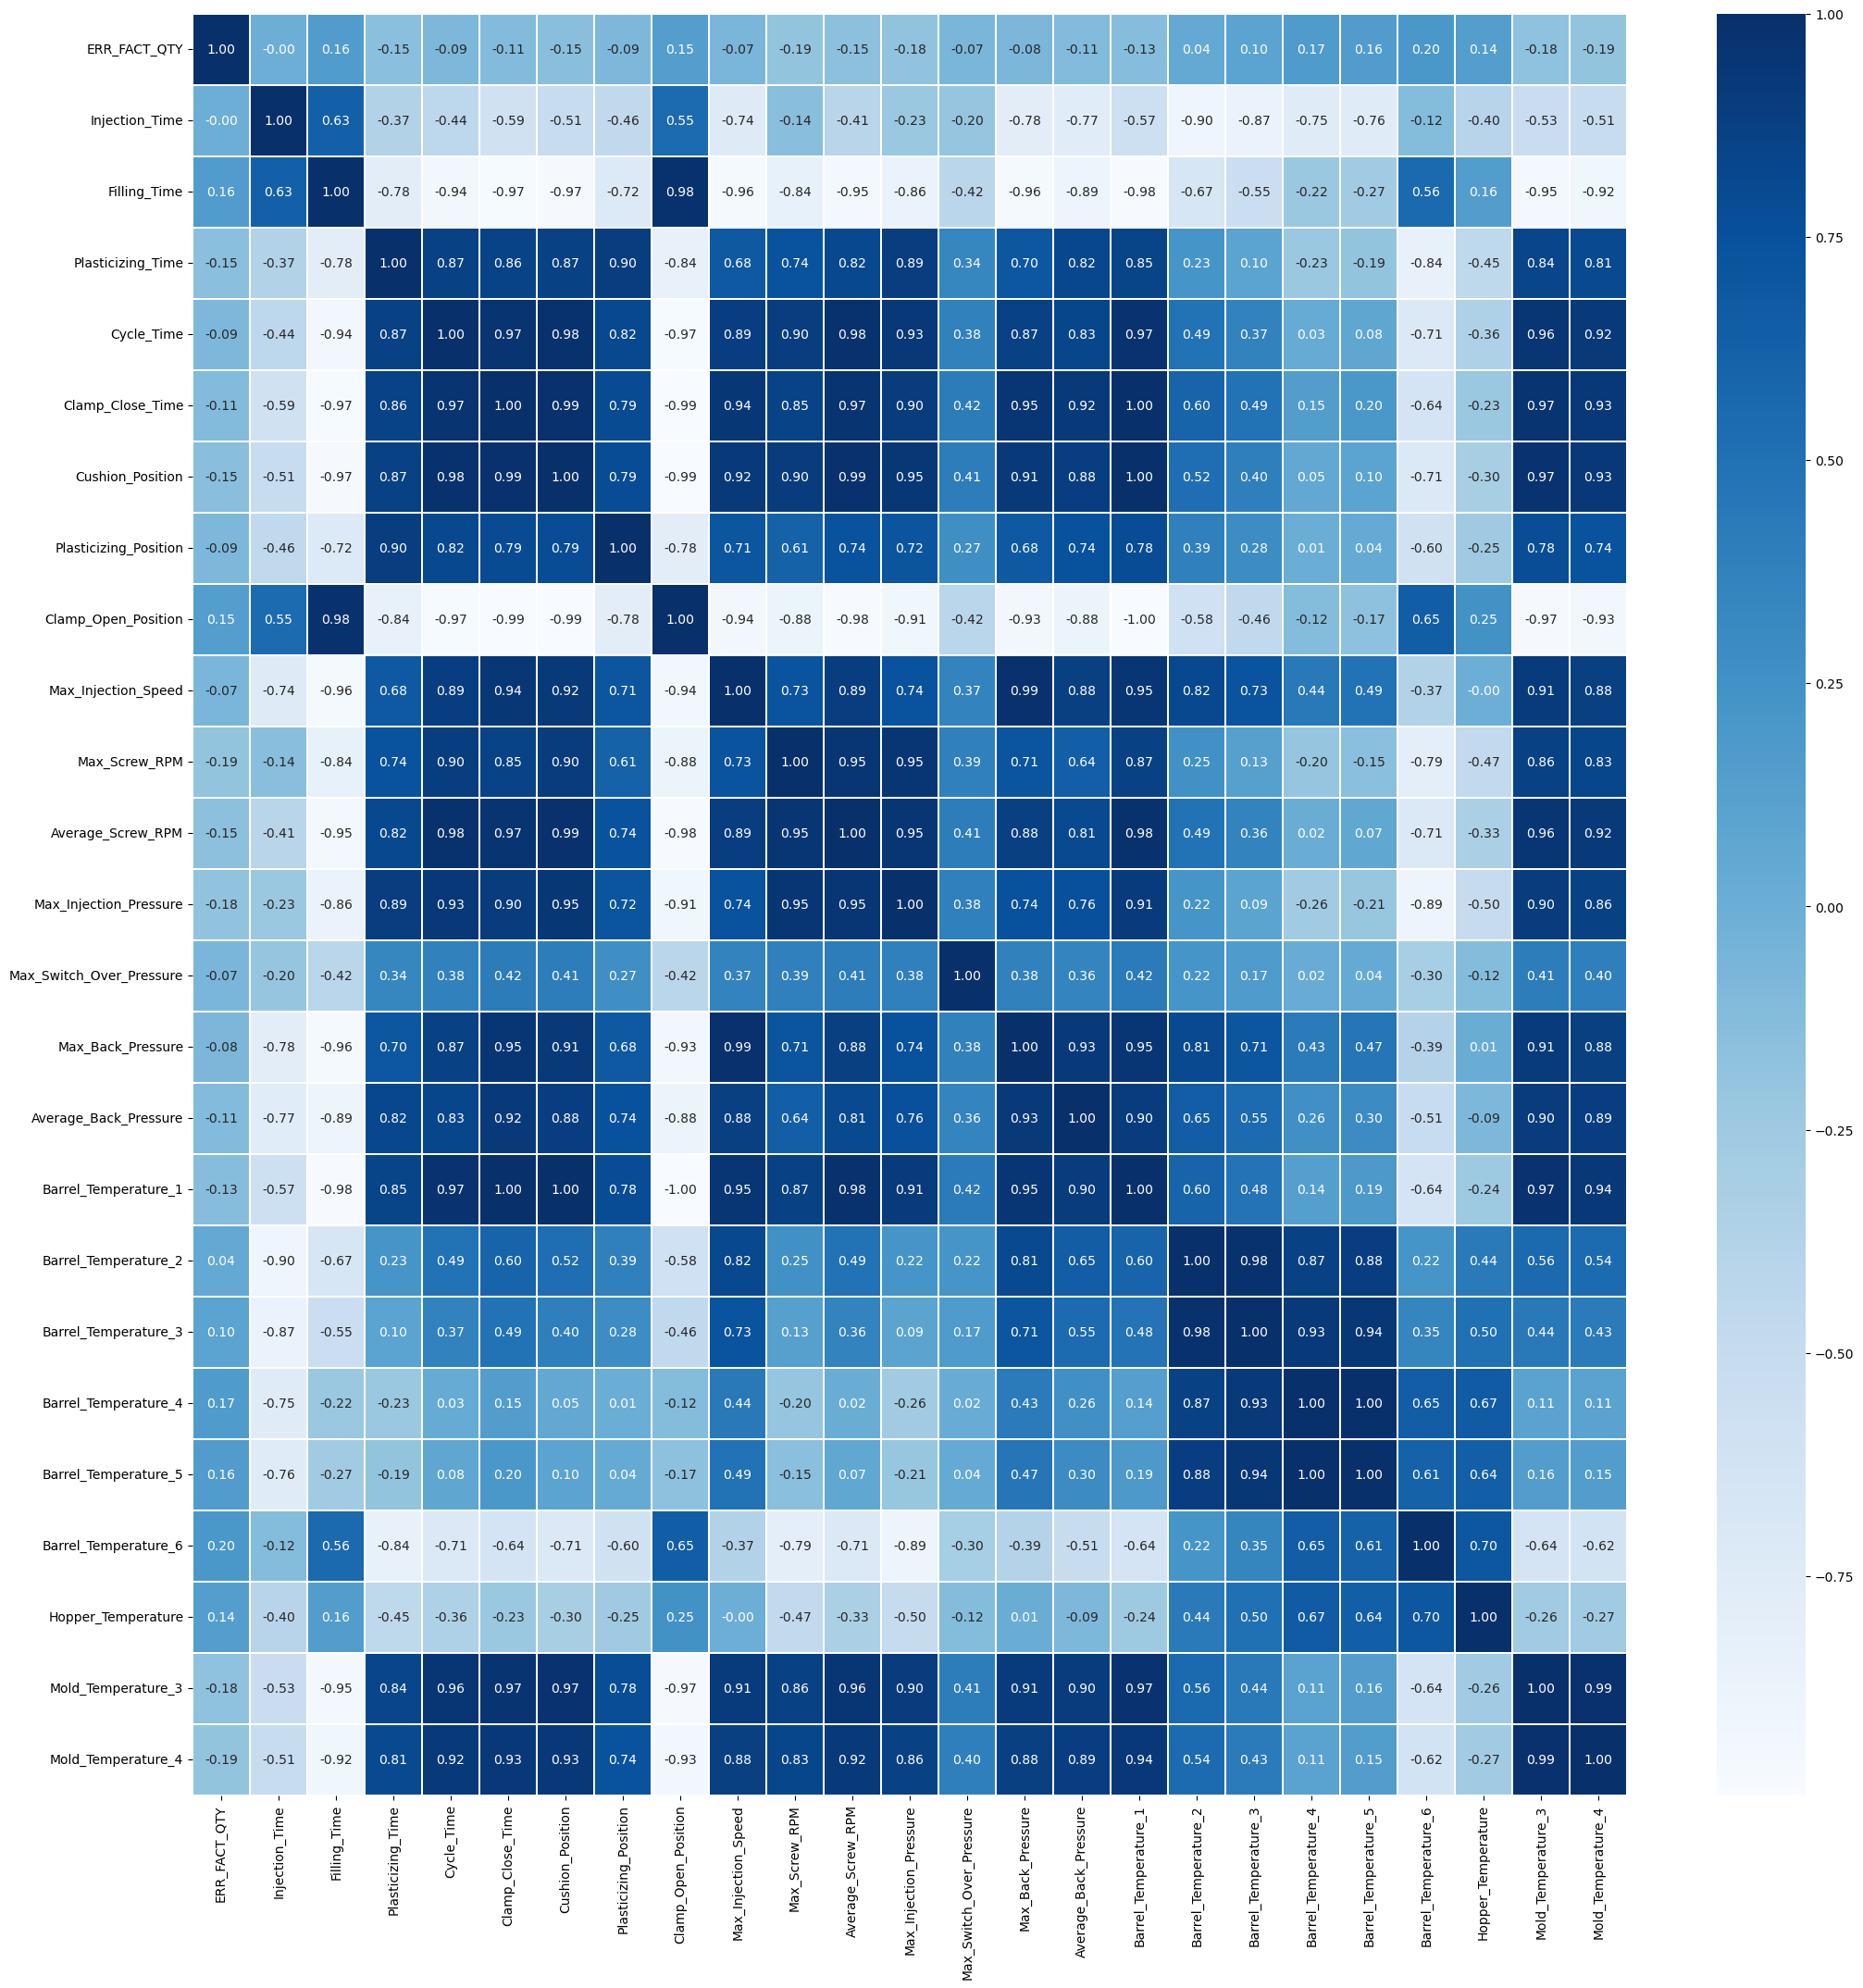

In [28]:
plt.subplots(figsize=[25,25])
sns.heatmap(data=moldset_unlabeled_rg3.corr(), linewidth=0.1,annot=True,fmt=".2f",cmap="Blues")

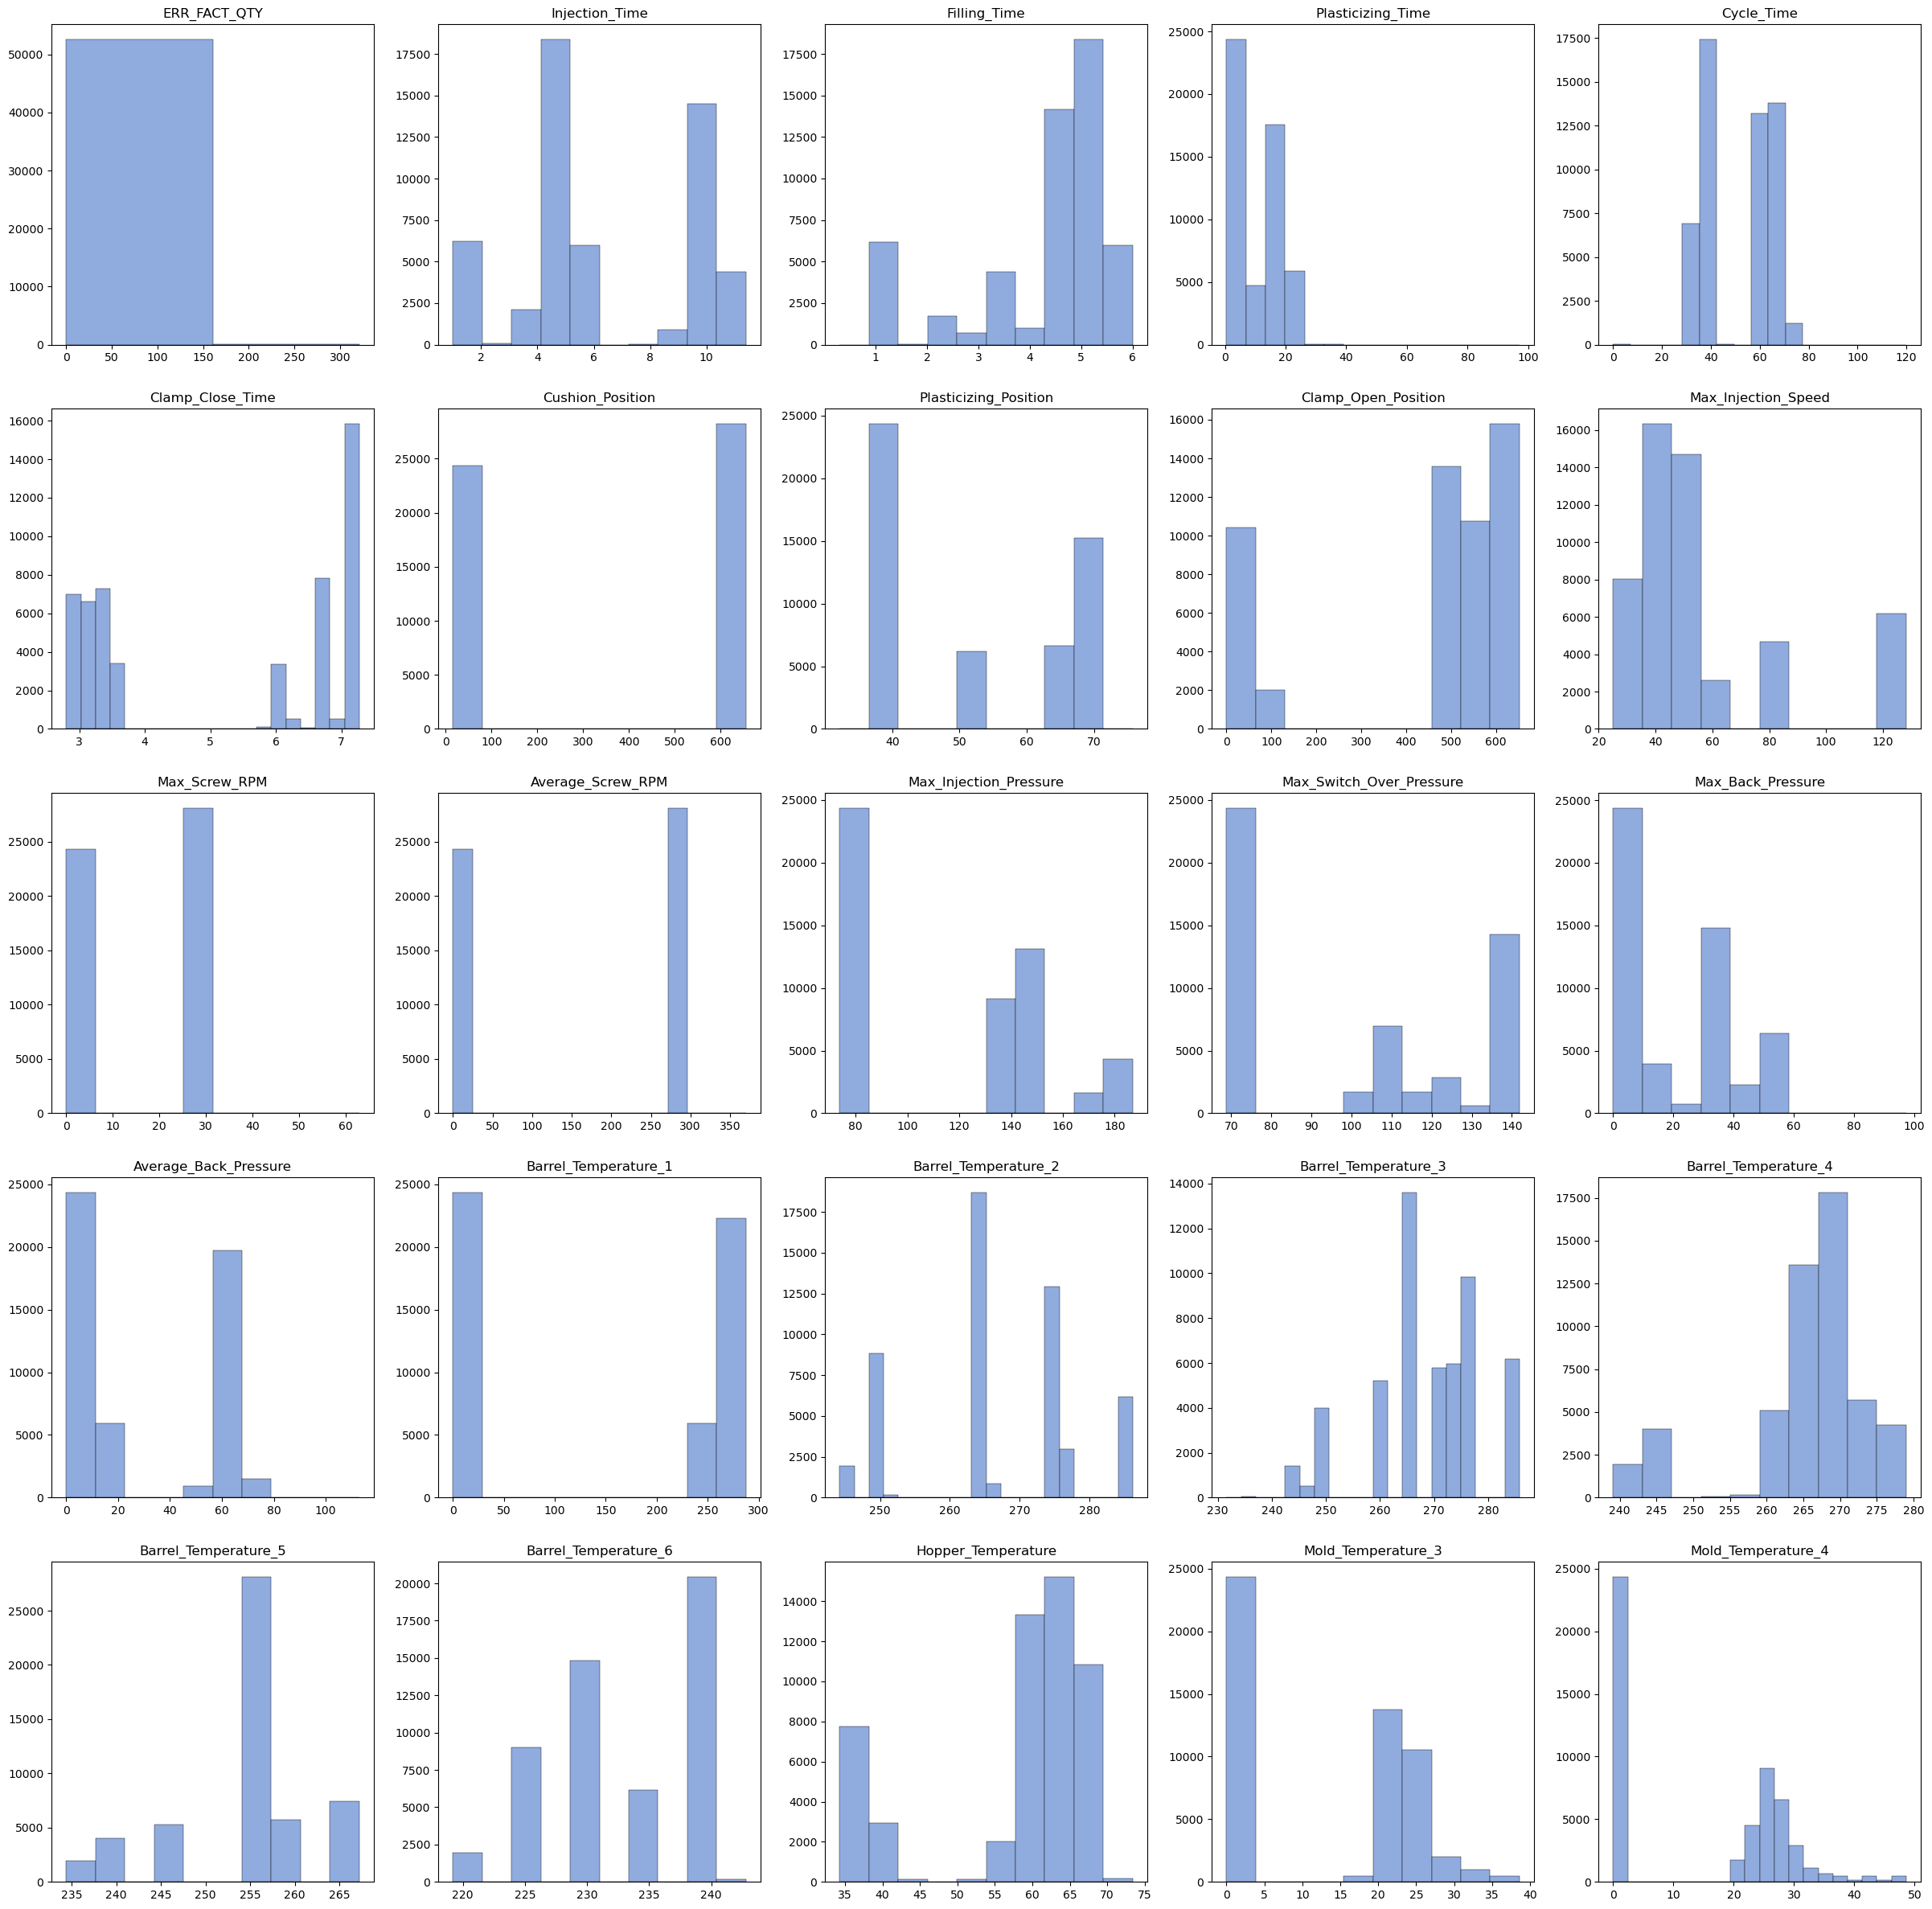

In [29]:
plt.figure(figsize=[30,30])

bins = [2,10,10,15,17,20,10,10,10,10,10,15,10,10,10,10,10,20,20,10,10,10,10,10,20,25,35,35]

for index, value in enumerate(moldset_unlabeled_rg3):
    sub = plt.subplot(5,5,index+1)
    sub.hist(moldset_unlabeled_cn7[value], bins=bins[index], facecolor=(144/255,171/255,221/255), linewidth=.3, edgecolor="black")
    plt.title(value)

# Data cleaning

In [30]:
moldset_labeled_cn7.loc[:, "PassOrFail"] = moldset_labeled_cn7.PassOrFail.astype("int")
moldset_labeled_rg3.loc[:, "PassOrFail"] = moldset_labeled_rg3.PassOrFail.astype("int")

In [31]:
moldset_labeled_cn7.PassOrFail.value_counts()

0    1398
1      27
Name: PassOrFail, dtype: int64

In [32]:
moldset_labeled_rg3.PassOrFail.value_counts()

0    1157
1      25
Name: PassOrFail, dtype: int64

In [33]:
data = [moldset_labeled_cn7, moldset_labeled_rg3, moldset_unlabeled_cn7, moldset_unlabeled_rg3]
for d in data:
    for column in d.columns:
        if column != "PassOrFail":
            sc = StandardScaler()
            d[[column]] = sc.fit_transform(d[[column]])

# Fill ERR_FACT_QTY value for labeled data by random forest regressor

In [34]:
moldset_labeled_cn7

,PassOrFail,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,...,Average_Back_Pressure,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
0,0,0.122110,0.094322,-0.282764,-0.025460,0.963650,-0.576792,1.667819,0.0,-0.382377,...,-0.205766,0.759767,-1.600222,-0.624789,-1.519760,0.008522,-1.305986,-0.955324,1.142850,1.425845
1,0,0.180385,0.152661,-0.330451,0.344778,0.963650,-0.576792,1.602311,0.0,-0.476945,...,-0.205766,0.085656,0.626666,0.935995,0.489887,-0.902204,-2.198113,-0.312243,1.142850,1.473445
2,0,0.180385,0.152661,-0.330451,0.344778,0.963650,-0.576792,1.602311,0.0,-0.476945,...,-0.205766,0.085656,0.626666,0.935995,0.489887,-0.902204,-2.198113,-0.312243,1.142850,1.473445
3,0,0.122110,0.152661,-0.330451,0.221365,0.963650,0.028457,1.602311,0.0,-0.476945,...,-0.205766,0.759767,-0.765160,1.248171,0.866724,-0.295068,0.032240,-0.526601,1.269794,1.473445
4,0,0.122110,0.152661,-0.330451,0.221365,0.963650,0.028457,1.602311,0.0,-0.476945,...,-0.205766,0.759767,-0.765160,1.248171,0.866724,-0.295068,0.032240,-0.526601,1.269794,1.473445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420,0,0.296929,0.327674,-0.902668,0.344778,-0.710983,1.844205,-0.035045,0.0,-0.476945,...,0.153128,1.209221,2.575257,0.311739,-0.012525,0.008522,1.816495,-1.241140,-0.888250,-0.716129
1421,0,0.355204,0.327674,-0.854991,0.221365,-0.710983,1.844205,0.030463,0.0,-0.571510,...,0.242850,-0.588525,2.018493,0.311739,1.117911,-0.295068,-1.752015,-1.455504,-0.888250,-0.763729
1422,0,0.355204,0.327674,-0.854991,0.221365,-0.710983,1.844205,0.030463,0.0,-0.571510,...,0.242850,-0.588525,2.018493,0.311739,1.117911,-0.295068,-1.752015,-1.455504,-0.888250,-0.763729
1423,0,0.296929,0.327674,-0.854991,0.344778,-0.710983,1.844205,-0.035045,0.0,-0.571510,...,0.153128,-1.037910,-0.765160,-0.936869,1.369136,0.008522,-0.859888,-1.312593,-0.888250,-0.763729


In [35]:
moldset_unlabeled_cn7

,ERR_FACT_QTY,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,...,Average_Back_Pressure,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
0,7.494344,1.246707,-0.795348,0.863032,1.595762,1.047931,0.928201,0.985601,0.922119,0.622018,...,0.229738,0.924564,0.741523,0.592352,0.527335,1.397654,1.078063,0.105895,0.751824,0.590949
1,7.494344,1.256639,-0.774580,0.864384,1.600250,1.047931,0.928138,1.000883,0.922119,0.605033,...,0.236632,0.929726,0.794409,0.612107,0.572229,1.397654,1.126010,0.133305,0.817496,0.696861
2,7.494344,1.253329,-0.774580,0.867088,1.595762,1.047931,0.928169,1.001647,0.922119,0.605033,...,0.229738,0.923827,0.697451,0.612107,0.527335,1.529007,1.030117,0.078485,0.686152,0.562706
3,7.494344,1.256639,-0.774580,0.861680,1.595762,1.047931,0.928232,1.001647,0.922119,0.608430,...,0.229738,0.926777,0.741523,0.661494,0.628347,1.397654,1.110027,0.078485,0.513764,0.372066
4,7.494344,1.256639,-0.774580,0.868440,1.600250,1.047931,0.928138,1.002411,0.922119,0.605033,...,0.229738,0.928252,0.688637,0.641740,0.549782,1.450195,1.046099,0.078485,0.571227,0.414430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52542,-0.715296,1.018267,0.118452,1.044208,0.639856,1.058634,0.927255,1.208717,0.905123,0.027535,...,1.101724,0.964387,0.723894,0.691127,0.650794,0.149796,-0.488181,1.010412,0.874958,0.696861
52543,-0.689641,0.995092,0.069993,1.160485,0.638360,1.058634,0.927318,1.204896,0.905123,0.081888,...,1.081045,0.960700,0.759151,0.612107,0.718136,0.136661,-0.520145,1.074368,0.874958,0.689800
52544,-0.715296,0.995092,0.069993,1.160485,0.638360,1.058634,0.927318,1.204896,0.905123,0.081888,...,1.081045,0.960700,0.759151,0.612107,0.718136,0.136661,-0.520145,1.074368,0.874958,0.689800
52545,-0.689641,0.971917,0.014611,1.441713,0.632376,1.058634,0.927381,1.187322,0.905123,0.139638,...,1.050025,0.963650,0.697451,0.671372,0.706912,0.110390,-0.440234,1.074368,0.874958,0.689800


In [36]:
moldset_unlabeled_cn7.loc[moldset_unlabeled_cn7.ERR_FACT_QTY < 0, "ERR_FACT_QTY"] = 0
moldset_unlabeled_rg3.loc[moldset_unlabeled_rg3.ERR_FACT_QTY < 0, "ERR_FACT_QTY"] = 0

<AxesSubplot:xlabel='ERR_FACT_QTY', ylabel='Count'>

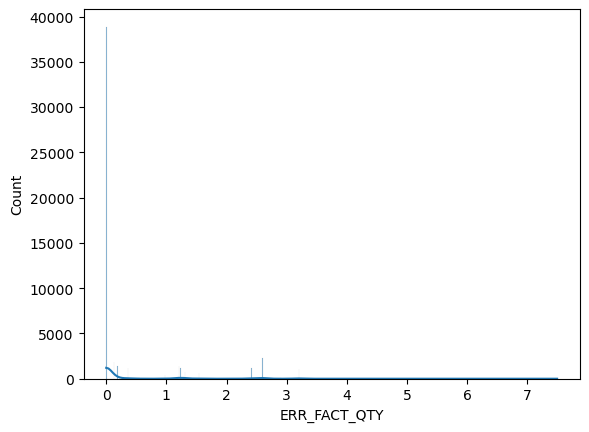

In [37]:
sns.histplot(moldset_unlabeled_cn7["ERR_FACT_QTY"], kde=True)

<AxesSubplot:xlabel='ERR_FACT_QTY', ylabel='Count'>

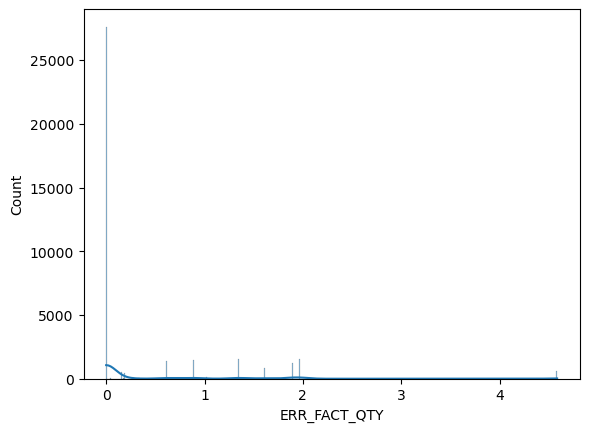

In [38]:
sns.histplot(moldset_unlabeled_rg3["ERR_FACT_QTY"], kde=True)

In [39]:
moldset_unlabeled_cn7_wo_d = moldset_unlabeled_cn7.drop_duplicates().reset_index(drop=True)
moldset_unlabeled_rg3_wo_d = moldset_unlabeled_rg3.drop_duplicates().reset_index(drop=True)

In [40]:
len(set(moldset_labeled_cn7.columns).intersection(set(moldset_unlabeled_cn7.columns)))

24

In [41]:
set(moldset_labeled_cn7.columns).difference(set(moldset_unlabeled_cn7.columns))

{'PassOrFail'}

In [42]:
set(moldset_unlabeled_cn7.columns).difference(set(moldset_labeled_cn7.columns))

{'ERR_FACT_QTY'}

In [43]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor

from tqdm.notebook import tqdm

K = 10
random_seed = 100

y_col = 'ERR_FACT_QTY'
np_X_col = moldset_unlabeled_cn7_wo_d.columns[np.where(moldset_unlabeled_cn7_wo_d.columns != y_col)[0]]

kfold = KFold(K, shuffle=True, random_state=random_seed)

list_rf_cn7 = list()
error_mean = 0

for idx, (idx_train, idx_test) in enumerate(tqdm(kfold.split(moldset_unlabeled_cn7_wo_d[np_X_col]))):
    X_train = moldset_unlabeled_cn7_wo_d.loc[idx_train, np_X_col]
    y_train = moldset_unlabeled_cn7_wo_d.loc[idx_train, y_col]
    
    X_test = moldset_unlabeled_cn7_wo_d.loc[idx_test, np_X_col]
    y_test = moldset_unlabeled_cn7_wo_d.loc[idx_test, y_col]
    
    rf = RandomForestRegressor(random_state=random_seed)
    
    rf.fit(X_train, y_train)
    y_test_pred = rf.predict(X_test)
    
    error = mean_squared_error(y_test, y_test_pred)
    error_mean_cn7 = (error_mean * idx + error) / (1 + idx)
    
    list_rf_cn7.append(rf)

0it [00:00, ?it/s]

In [44]:
error_mean_cn7

0.0077479077347347575

In [45]:
np_X_col.tolist()

['Injection_Time',
 'Filling_Time',
 'Plasticizing_Time',
 'Cycle_Time',
 'Clamp_Close_Time',
 'Cushion_Position',
 'Plasticizing_Position',
 'Clamp_Open_Position',
 'Max_Injection_Speed',
 'Max_Screw_RPM',
 'Average_Screw_RPM',
 'Max_Injection_Pressure',
 'Max_Switch_Over_Pressure',
 'Max_Back_Pressure',
 'Average_Back_Pressure',
 'Barrel_Temperature_1',
 'Barrel_Temperature_2',
 'Barrel_Temperature_3',
 'Barrel_Temperature_4',
 'Barrel_Temperature_5',
 'Barrel_Temperature_6',
 'Hopper_Temperature',
 'Mold_Temperature_3',
 'Mold_Temperature_4']

In [46]:
label = "PassOrFail"
list_X_col = moldset_labeled_cn7.columns[np.where(moldset_labeled_cn7.columns != label)[0]].tolist()

y_moldset_labeled_cn7 = np.mean([rf.predict(moldset_labeled_cn7[list_X_col]) for rf in list_rf_cn7], axis=0)

In [47]:
y_moldset_labeled_cn7

array([0.09704244, 0.09731792, 0.09731792, ..., 1.15773532, 1.06483988,
       1.06483988])

In [48]:
moldset_labeled_cn7[y_col] = y_moldset_labeled_cn7

In [49]:
moldset_labeled_cn7.loc[moldset_labeled_cn7[y_col] * moldset_labeled_cn7[label] > 0]

,PassOrFail,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,...,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4,ERR_FACT_QTY
47,1,0.063835,0.094322,-0.425823,-0.025460,0.963650,-0.576792,1.602311,0.0,-0.382377,...,-0.139071,-0.208395,0.311739,1.243523,0.615658,0.924367,0.116485,1.269794,1.425845,0.023374
80,1,0.180385,0.152661,-0.282764,-0.025460,0.963650,-0.576792,1.602311,0.0,-0.476945,...,-0.363798,0.905049,-0.000437,-0.389324,1.526384,0.924367,-0.598054,1.396738,1.521044,0.024729
95,1,0.122110,0.152661,-0.139706,-0.025460,0.963650,0.028457,1.602311,0.0,-0.476945,...,-0.139071,2.853555,0.623915,-0.514936,-2.723610,1.816495,0.616660,1.396738,1.521044,0.082686
99,1,0.122110,0.094322,-0.235078,0.221365,0.963650,-0.576792,1.602311,0.0,-0.287812,...,-1.037910,0.348284,-1.873397,0.615499,0.312113,-1.305986,-0.240785,1.333266,1.521044,0.104152
101,1,0.063835,0.094322,-0.235078,0.221365,0.963650,-0.576792,1.602311,0.0,-0.287812,...,1.209221,-1.321925,0.311739,1.117911,0.312113,-1.305986,-0.455149,1.396738,1.521044,0.227526
103,1,0.005560,0.035986,-0.378137,-0.025460,0.963650,-0.576792,1.667819,0.0,-0.287812,...,0.984494,-0.208395,0.311739,1.243523,-0.902204,0.478338,0.187938,1.333266,1.521044,0.208622
105,1,0.005560,0.035986,-0.282764,-0.025460,0.963650,-0.576792,1.602311,0.0,-0.287812,...,-0.588525,-1.043542,1.872523,0.741112,1.222793,1.370465,-0.383696,1.333266,1.521044,0.047859
107,1,-0.052710,-0.080689,-0.282764,-0.025460,0.963650,-0.576792,1.602311,0.0,-0.004115,...,-2.161475,-1.600222,-2.185573,0.113088,-0.902204,0.478338,-0.097879,1.269794,1.473445,0.155659
109,1,-0.052710,-0.022353,-0.282764,-0.025460,2.638203,-0.576792,1.602311,0.0,-0.004115,...,0.085656,-0.208395,0.623915,-0.514936,0.312113,1.816495,-0.383696,1.142850,1.425845,1.278728
111,1,0.063835,0.035986,-0.139706,-0.025460,2.638203,-0.576792,1.733327,0.0,-0.287812,...,2.108059,0.069902,0.311739,-1.142960,0.919249,-0.859888,0.116485,1.269794,1.521044,0.024681


In [50]:
moldset_labeled_cn7.loc[:, "reward"] = 0
moldset_labeled_cn7.loc[moldset_labeled_cn7[y_col] * moldset_labeled_cn7[label] > 0, "reward"] = moldset_labeled_cn7[y_col] * moldset_labeled_cn7[label]

moldset_labeled_cn7

,PassOrFail,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,...,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4,ERR_FACT_QTY,reward
0,0,0.122110,0.094322,-0.282764,-0.025460,0.963650,-0.576792,1.667819,0.0,-0.382377,...,-1.600222,-0.624789,-1.519760,0.008522,-1.305986,-0.955324,1.142850,1.425845,0.097042,0.0
1,0,0.180385,0.152661,-0.330451,0.344778,0.963650,-0.576792,1.602311,0.0,-0.476945,...,0.626666,0.935995,0.489887,-0.902204,-2.198113,-0.312243,1.142850,1.473445,0.097318,0.0
2,0,0.180385,0.152661,-0.330451,0.344778,0.963650,-0.576792,1.602311,0.0,-0.476945,...,0.626666,0.935995,0.489887,-0.902204,-2.198113,-0.312243,1.142850,1.473445,0.097318,0.0
3,0,0.122110,0.152661,-0.330451,0.221365,0.963650,0.028457,1.602311,0.0,-0.476945,...,-0.765160,1.248171,0.866724,-0.295068,0.032240,-0.526601,1.269794,1.473445,0.204066,0.0
4,0,0.122110,0.152661,-0.330451,0.221365,0.963650,0.028457,1.602311,0.0,-0.476945,...,-0.765160,1.248171,0.866724,-0.295068,0.032240,-0.526601,1.269794,1.473445,0.204066,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420,0,0.296929,0.327674,-0.902668,0.344778,-0.710983,1.844205,-0.035045,0.0,-0.476945,...,2.575257,0.311739,-0.012525,0.008522,1.816495,-1.241140,-0.888250,-0.716129,1.180156,0.0
1421,0,0.355204,0.327674,-0.854991,0.221365,-0.710983,1.844205,0.030463,0.0,-0.571510,...,2.018493,0.311739,1.117911,-0.295068,-1.752015,-1.455504,-0.888250,-0.763729,1.157735,0.0
1422,0,0.355204,0.327674,-0.854991,0.221365,-0.710983,1.844205,0.030463,0.0,-0.571510,...,2.018493,0.311739,1.117911,-0.295068,-1.752015,-1.455504,-0.888250,-0.763729,1.157735,0.0
1423,0,0.296929,0.327674,-0.854991,0.344778,-0.710983,1.844205,-0.035045,0.0,-0.571510,...,-0.765160,-0.936869,1.369136,0.008522,-0.859888,-1.312593,-0.888250,-0.763729,1.064840,0.0


In [51]:
K = 10
random_seed = 100

y_col = 'ERR_FACT_QTY'
list_X_col = moldset_unlabeled_rg3_wo_d.columns[np.where(moldset_unlabeled_rg3_wo_d.columns != y_col)[0]].tolist()

kfold = KFold(K, shuffle=True, random_state=random_seed)

list_rf_rg3 = list()
error_mean_rg3 = 0

for idx, (idx_train, idx_test) in enumerate(tqdm(kfold.split(moldset_unlabeled_rg3_wo_d[list_X_col]))):
    X_train = moldset_unlabeled_rg3_wo_d.loc[idx_train, list_X_col]
    y_train = moldset_unlabeled_rg3_wo_d.loc[idx_train, y_col]
    
    X_test = moldset_unlabeled_rg3_wo_d.loc[idx_test, list_X_col]
    y_test = moldset_unlabeled_rg3_wo_d.loc[idx_test, y_col]
    
    rf = RandomForestRegressor(random_state=random_seed)
    
    rf.fit(X_train, y_train)
    y_test_pred = rf.predict(X_test)
    
    error = mean_squared_error(y_test, y_test_pred)
    error_mean_rg3 = (error_mean_rg3 * idx + error) / (1 + idx)
    
    list_rf_rg3.append(rf)

0it [00:00, ?it/s]

In [52]:
error_mean_rg3

0.10317340889147404

In [53]:
label = "PassOrFail"
np_X_col = moldset_labeled_rg3.columns[np.where(moldset_labeled_rg3.columns != label)[0]]

y_moldset_labeled_rg3 = np.mean([rf.predict(moldset_labeled_rg3[np_X_col]) for rf in list_rf_rg3], axis=0)

In [54]:
y_moldset_labeled_rg3

array([0.32985148, 0.32985148, 0.53028234, ..., 0.2210372 , 0.09712144,
       0.09712144])

In [55]:
moldset_labeled_rg3[y_col] = y_moldset_labeled_rg3

In [56]:
moldset_labeled_rg3.loc[moldset_labeled_rg3[y_col] * moldset_labeled_rg3[label] > 0]

,PassOrFail,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,...,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4,ERR_FACT_QTY
136,1,-0.029099,-1.192531,-0.042538,0.249511,-0.386790,0.480326,-0.192928,0.0,0.617645,...,0.562844,-1.950268,0.919808,-0.829743,1.223110,-0.851297,1.200026,-1.108521,-0.969082,0.563399
160,1,-0.029099,-1.192531,0.406400,0.249511,-0.386790,0.480326,-0.192928,0.0,0.617645,...,-0.136479,0.715557,-0.616737,-0.537231,-0.657751,-1.845598,0.081547,-0.823555,-0.847689,0.449500
170,1,-0.029099,-1.192531,0.855360,0.249511,-0.386790,1.277707,0.588367,0.0,0.617645,...,0.329736,0.230835,-0.002081,0.778986,-0.030765,0.143005,0.386588,-0.823555,-0.969082,0.101380
204,1,-0.029099,-1.192531,-0.491498,0.249511,-0.386790,0.480326,0.588367,0.0,0.617645,...,1.495203,-1.465546,-0.002081,1.656478,-0.344258,0.143005,1.200026,-0.823555,-0.847689,1.866449
244,1,-0.029099,-1.192531,0.406400,0.249511,-0.386790,1.277707,-0.192928,0.0,1.402554,...,0.795880,0.473196,-0.309409,1.363966,0.596220,-0.851297,0.284910,-0.823555,-0.847689,0.534666
300,1,-0.029099,0.838552,0.181942,0.249511,1.033078,0.480326,-1.755816,0.0,0.617645,...,-0.602623,-0.011452,-0.002081,0.340262,0.282727,0.640193,0.589944,-0.396108,-0.483514,0.103710
304,1,-0.029099,0.838552,1.528778,0.249511,1.033078,0.480326,-0.974521,0.0,0.617645,...,0.795880,1.442567,-0.002081,0.632729,-0.344258,0.143005,0.589944,-0.538588,-0.483514,0.115286
310,1,-0.029099,-1.192531,1.753258,-0.298708,1.033078,1.277707,-0.974521,0.0,1.402554,...,0.329736,-1.223184,-0.002081,-0.683487,0.596220,1.634495,0.589944,-0.111141,-0.362122,1.876622
322,1,-0.029099,0.838552,0.630880,-0.846822,1.033078,0.480326,-0.192928,0.0,0.617645,...,-1.068838,-0.980897,0.305246,1.802734,0.282727,0.640193,0.691629,-0.253624,-0.362122,0.047726
346,1,-0.029099,-1.192531,0.855360,0.249511,1.033078,0.480326,-0.974521,0.0,0.617645,...,0.096629,-0.011452,0.612574,-0.829743,0.282727,-0.354184,-0.223487,0.031342,-0.240729,0.161632


In [57]:
moldset_labeled_rg3.loc[:, "reward"] = 0
moldset_labeled_rg3.loc[moldset_labeled_rg3[y_col] * moldset_labeled_rg3[label] > 0, "reward"] = moldset_labeled_rg3[y_col] * moldset_labeled_rg3[label]

moldset_labeled_rg3

,PassOrFail,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,...,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4,ERR_FACT_QTY,reward
0,0,-0.029099,-1.192531,1.977737,0.249511,1.033078,2.867608,-1.755816,0.0,2.187583,...,-0.496175,-0.002081,0.047749,0.282727,-0.354184,0.183232,-1.393485,-1.576042,0.329851,0.0
1,0,-0.029099,-1.192531,1.977737,0.249511,1.033078,2.867608,-1.755816,0.0,2.187583,...,-0.496175,-0.002081,0.047749,0.282727,-0.354184,0.183232,-1.393485,-1.576042,0.329851,0.0
2,0,-0.029099,-1.192531,1.528778,0.249511,1.033078,2.075089,-0.192928,0.0,2.187583,...,1.442567,-0.002081,0.340262,1.850096,-0.851297,0.183232,-1.535968,-1.576042,0.530282,0.0
3,0,-0.029099,-1.192531,1.528778,0.249511,1.033078,2.075089,-0.192928,0.0,2.187583,...,1.442567,-0.002081,0.340262,1.850096,-0.851297,0.183232,-1.535968,-1.576042,0.530282,0.0
4,0,-0.029099,-1.192531,0.630880,-0.298708,1.033078,1.277707,-1.755816,0.0,1.402554,...,-0.253813,-0.002081,0.925242,0.282727,-1.348485,0.284910,-1.535968,-1.576042,0.692971,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177,0,-0.029099,0.838552,-1.164915,-0.298708,-0.386790,-1.114437,0.588367,0.0,-0.952293,...,-0.011452,-0.002081,0.925242,0.282727,1.634495,-0.020131,1.598652,1.701543,0.083606,0.0
1178,0,-0.029099,0.838552,-1.613854,-0.846822,-1.806725,-1.114437,1.369662,0.0,-1.737322,...,-0.253813,-0.002081,0.925242,-0.971148,-1.348485,-0.020131,1.456169,1.701543,0.221037,0.0
1179,0,-0.029099,0.838552,-1.613854,-0.846822,-1.806725,-1.114437,1.369662,0.0,-1.737322,...,-0.253813,-0.002081,0.925242,-0.971148,-1.348485,-0.020131,1.456169,1.701543,0.221037,0.0
1180,0,-0.029099,0.838552,-0.491498,-1.395040,-0.386790,-0.317055,1.369662,0.0,-0.952293,...,1.442567,-0.616737,0.486518,-0.030765,-0.851297,-0.121809,1.456169,1.701543,0.097121,0.0


# Implemented classes for proposed method

## Environment for sequential learning of proposed method

In [58]:
class Env:
    def __init__(self, np_X, np_X_cols, np_err_qty, np_label, fimtdd, max_leaf, is_train=True):
        self.np_X = np_X
        self.df_X = pd.DataFrame(np_X, columns=np_X_cols)
        self.np_err_qty = np_err_qty
        self.np_label = np_label
        self.np_class = np.array([None for idx in range(np_X.shape[0])])
        
        self.fimtdd = None
        self.max_leaf = max_leaf
        self.is_update = False
        self.is_done = False
        
        self.is_train = is_train
        self.n_train = np_X.shape[0] if len(np.where(self.np_label == None)[0])==0 else min(np.where(self.np_label == None)[0]) 
        self.n_test = np_X.shape[0] - self.n_train
        
        self.np_reward = self.generate_reward()
        
        self.k = 0
        self.t = 0
        self.d = self.np_X.shape[1]
        _ = self.set_fimtdd(fimtdd)
             
    def generate_reward(self):
        if len(np.where(self.np_label == None)[0]) == 0:
            reward = self.np_label * self.np_err_qty
            np_reward = np.array(list(map(lambda x: x if x > 0 else 0, reward)))
            
        else:
            reward = self.np_label[:self.n_train] * self.np_err_qty[:self.n_train]
            np_reward = np.array(list(map(lambda x: x if x > 0 else 0, reward)))
            n_none = self.np_X.shape[0] - self.n_train
            np_reward = np.hstack([np_reward, [None for idx in range(n_none)]])
        
        return np_reward
        
    def get_observation(self):
        
        np_context = self.np_X[self.t].reshape(-1,1)
    
        self.t+=1
        
        return np_context
    
    def get_reward(self, idx_est_arm):
        if self.is_train:
            if idx_est_arm != self.np_class[self.t-1]:
                reward = None
            else:
                reward = self.np_reward[self.t-1]
        else:
            label = 1 if idx_est_arm == self.idx_max_class else 0
            reward = label * self.np_err_qty[self.t-1]

            self.np_label[self.t-1] = label
            self.np_class[self.t-1] = idx_est_arm
            self.np_reward[self.t-1] = reward

        if self.t == self.n_train:
            self.is_train = False
            
        return reward
            
    def convert_comb_to_idx(self, X, col, eq, value):
        if eq == "<=":
            return X.loc[:, X.columns[col]] <= value
        elif eq == ">=":
            return X.loc[:, X.columns[col]] >= value
        elif eq == "<":
            return X.loc[:, X.columns[col]] < value
        elif eq == ">":
            return X.loc[:, X.columns[col]] > value
    
    def set_fimtdd(self, fimtdd):    
        p_eq = "<=|>=|<|>"
        p_attr = "Att \([0-9]+\)"
        p_col = "([0-9]+)"
        
        list_rules = [rule.get_rule().split("|")[0].strip().split(" and") for rule in fimtdd.get_model_rules()]
        n_rules = len(list_rules)
        
        if self.fimtdd is not None and self.k != n_rules and n_rules <= self.max_leaf:
            self.is_update = True
        
        elif self.fimtdd is not None and self.k != n_rules and n_rules > self.max_leaf:
            self.is_update = False
            self.is_done = True
            
        else:
            self.fimtdd = fimtdd
            self.k = n_rules
            
            list_rule_comb = list(map(lambda x: (np.sum([self.convert_comb_to_idx(self.df_X.iloc[:self.n_train, ], int(re.search(p_col,r).group()), re.search(p_eq,r).group(), float(re.sub(p_eq,"",re.sub(p_attr,"",r)).strip())) for r in x], axis=0)==len(x)),list_rules))
            np_rule_comb = np.vstack(list_rule_comb)
            
            self.dict_class_to_leaf = {idx_class:np.where(np_rule_comb[idx_class])[0] for idx_class in range(np_rule_comb.shape[0])}
            
            for k,v in self.dict_class_to_leaf.items():
                self.np_class[v] = k
            
            self.dict_class_reward = {k:self.np_reward[v].mean() if v.shape[0] != 0 else 0 for k,v in self.dict_class_to_leaf.items()}
            
            self.idx_max_class = np.argmax(list(self.dict_class_reward.values()))
            
        return self.is_update

## CMAB algorithm (LinUCB)

In [59]:
class LinUCB:
    """
    LinUCB Algorithm
    
    parameters
    ----------
    k: The number of arm for bandit algorithm
    d: The number of dimension for bandit algorithm
    alpha: The intensity of exploration of UCB function
    seed: Random state for generating dataset
    """    
    def __init__(self, k, d, alpha, lamb=1):
        self.k = k 
        self.d = d
        self.alpha = alpha
        self.lamb = lamb
        self.ucbs = None
        
        self.dict_A, self.dict_b, self.list_arms, self.list_rewards = self.init_ucb()
        
    # initialize estimates for LinUCB
    def init_matrix(self):
        identity_matrix = np.eye(self.d)
        zero_vector = np.zeros((self.d,1))

        return (1/self.lamb) * identity_matrix, zero_vector

    # initialize ucb estimates and history
    def init_ucb(self):
        A,b = self.init_matrix()
        
        dict_A = {idx_k: deepcopy(A) for idx_k in range(self.k)} 
        dict_b = {idx_k: deepcopy(b) for idx_k in range(self.k)}
        
        list_arms = list()
        list_rewards = list()
        
        return dict_A, dict_b, list_arms, list_rewards

    # LinUCB algorithm
    def select_by_ucb(self, observation):
        
        # get UCB value per given arms
        self.np_ucbs = np.hstack([self.dict_A[idx_k] @ self.dict_b[idx_k] for idx_k in range(self.k)]).T @ observation + np.vstack([self.alpha * observation.T @ A @ observation for idx_k, A in self.dict_A.items()])
        
        # get candidate arms which have ucb value
        idx_ucb_arm = np.random.choice(np.where(self.np_ucbs == self.np_ucbs.max())[0])
        
        return idx_ucb_arm

    # execute pull actions given observation by LinUCB algorithm
    def pull(self, observation):

        idx_est_arm = self.select_by_ucb(observation)

        return idx_est_arm
    
    # update estimates by selected action and reward
    def update(self, obs, idx_arm, reward):

        self.list_arms.append(idx_arm)
        self.list_rewards.append(reward)
        
        A = self.dict_A[idx_arm]
        b = self.dict_b[idx_arm]
        
        # update inverse matrix by sherman-morrison formula
        A -= ((A @ obs @ obs.T @ A) / (1 + obs.T @ A @ obs))  
        b += (obs * reward)

        self.dict_A[idx_arm] = A 
        self.dict_b[idx_arm] = b
        
    def get_pseudo_reward(self, obs, idx_ucb_arm, reward):
        pi_ts = np.exp(self.np_ucbs) / np.exp(self.np_ucbs).sum()
        if reward is None:
            estimate = obs.T @ (self.dict_A[idx_ucb_arm] @ self.dict_b[idx_ucb_arm])
            pseudo_reward = ((1 - (1 / pi_ts[idx_ucb_arm])) * estimate).reshape(-1)
        else:
            pseudo_reward = ((1 / pi_ts[idx_ucb_arm]) * reward)
            
        return pseudo_reward

## Class for executing proposed method

In [60]:
class UCBLauncher:
    def __init__(self, iteration, K, df_labeled, df_unlabeled, data_type, label_col, qty_col, y_col, list_cols, seed, verbose=True):
        
        self.iteration = iteration
        self.K = K
        self.seed = seed
        self.verbose = verbose
        
        self.df_labeled = df_labeled
        self.df_unlabeled = df_unlabeled
        self.data_type = data_type
        self.label_col = label_col
        self.qty_col = qty_col
        self.y_col = y_col
        self.list_cols = list_cols
                
    def init_data(self, is_norm=True):
        if is_norm:
            np_X_labeled = normalize(self.df_labeled.loc[:, self.list_cols].values)
            np_X_unlabeled = normalize(self.df_unlabeled.loc[:, self.list_cols].values)
        else:
            np_X_labeled = self.df_labeled.loc[:, self.list_cols].values
            np_X_unlabeled = self.df_unlabeled.loc[:, self.list_cols].values
        
        list_split_seeds_cn7 = [9, 41, 84]
        list_split_seeds_rg3 = [0, 2, 4]
        
        seed = list_split_seeds_cn7[0] if self.data_type == "cn7" else list_split_seeds_rg3[0]
        
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=seed)
        
        idx_split = [(train_idx, test_idx) for train_idx, test_idx in sss.split(np_X_labeled, self.df_labeled[self.label_col])]
        
        np_X_labeled_train = np_X_labeled[idx_split[0][0], :]
        np_X_labeled_test = np_X_unlabeled[idx_split[0][1], :]

        # y_col = "reward"
        y_labeled_train = self.df_labeled.loc[idx_split[0][0], self.y_col].values
        y_labeled_test = self.df_labeled.loc[idx_split[0][1], self.y_col].values

        df_labeled_train = self.df_labeled.loc[idx_split[0][0], :].reset_index()
        df_labeled_test = self.df_labeled.loc[idx_split[0][1], :].reset_index()
        
        np_X = np.vstack([np_X_labeled_train, np_X_unlabeled])
        self.t_horizon = np_X.shape[0]
        
        np_err_qty = np.hstack([df_labeled_train[self.qty_col].values, self.df_unlabeled[self.qty_col].values])
        np_label = np.hstack([df_labeled_train[self.label_col].values,[None for idx in range(self.df_unlabeled.shape[0])]])
        
        return (np_X_labeled_train, np_X_labeled_test), (y_labeled_train, y_labeled_test), (np_X, np_err_qty, np_label), df_labeled_test
    
    def fit_fimtdd(self, X, y):
        fimtdd = RegressionHoeffdingTree(random_state=self.seed)
        fimtdd.fit(X,y)
        
        return fimtdd
    
    def launch(self):
        self.list_fimtdd = list()
        self.list_linucb = list()
        
        for simul in tqdm(range(self.iteration)) if self.verbose else range(self.iteration):
            (self.np_X_labeled_train, self.np_X_labeled_test), (self.y_labeled_train, self.y_labeled_test), (self.np_X, self.np_err_qty, self.np_label), self.df_labeled_test = self.init_data()
            fimtdd = self.fit_fimtdd(self.np_X_labeled_train, self.y_labeled_train)
            env = Env(self.np_X, self.list_cols, self.np_err_qty, self.np_label, fimtdd, self.K)

            k = env.k
            d = env.d

            linucb = LinUCB(k,d,0.5)
            
            i = 0
            begin = time.time()
            
            while True:
                i+=1
                begin_iter = time.time()
                
                if i != 1:
                    env = Env(self.np_X, self.list_cols, self.np_err_qty, self.np_label, fimtdd, self.K)
                    k = env.k
                    d = env.d
                    linucb = LinUCB(k,d,0.5)
                
                if self.verbose:
                    print(f"iteration: {i}; n_rules:{env.k}")

                for t in range(self.t_horizon):
                    obs = env.get_observation()

                    idx_ucb_arm = linucb.pull(obs)
                    ucb_reward = env.get_reward(idx_ucb_arm)
                    pseudo_reward = linucb.get_pseudo_reward(obs, idx_ucb_arm, ucb_reward)
                    
                    if env.is_train == False:
                        if env.is_done == False:
                            fimtdd.partial_fit(obs.reshape(1,24), np.array([pseudo_reward]))
                            is_update = env.set_fimtdd(fimtdd)
                            if is_update:
                                self.np_label = env.np_label
                                break

                    linucb.update(obs, idx_ucb_arm, pseudo_reward)

                end_iter = time.time()

                t_iter= round(end_iter - begin_iter)
                t_total= round(end_iter - begin)

                if t == self.t_horizon-1:
                    self.list_linucb.append(linucb)
                    self.list_fimtdd.append(fimtdd)
                    if self.verbose:
                        print(f"iteration: {i}; rows: {self.np_label.shape[0]} | {self.t_horizon}; time: {t_iter // 60} min {t_iter % 60} sec | {t_total // 60} min {t_total % 60} sec;")
                    break

                else:
                    if self.verbose:
                        print(f"iteration: {i}; rows: {min(np.where(self.np_label == None)[0])} | {self.t_horizon}; time: {t_iter // 60} min {t_iter % 60} sec | {t_total // 60} min {t_total % 60} sec;")

    def predict(self):
        np_err_qty_test = deepcopy(self.df_labeled_test[self.qty_col].values)
        np_label_test = deepcopy(self.df_labeled_test[self.label_col].values)
        
        list_envs = [ Env(self.np_X_labeled_test, self.list_cols, np_err_qty_test, np_label_test, self.list_fimtdd[simul], self.K, is_train=False) for simul in range(self.iteration)]
        list_ks = [env.k for env in list_envs]
        
        list_idx_max_class = [env.idx_max_class for env in list_envs]
        
        t_horizon = self.np_X_labeled_test.shape[0]
        
        list_ucb_arms = list()
        list_rewards = list()
        list_preds = list()
        for t in tqdm(range(t_horizon)) if self.verbose else range(t_horizon):
            list_obs = [env.get_observation() for env in list_envs]
            
            idx_ucb_arms = [linucb.pull(list_obs[idx]) for idx, linucb in enumerate(self.list_linucb)]
            
            rewards = [env.get_reward(idx_ucb_arms[idx]) for idx, env in enumerate(list_envs)]
            
            labels = [1 if idx_ucb_arms[idx] == list_idx_max_class[idx] else 0 for idx, env in enumerate(list_envs)]
            
            list_ucb_arms.append(idx_ucb_arms)
            list_rewards.append(rewards)
            list_preds.append(labels)
            
        return list_envs, list_ucb_arms, list_rewards, list_preds

# Train proposed method for CN7 and RG3

## CN7

In [61]:
list_k = [3,4,5,6]

list_launchers_cn7 = list()

for k in list_k:
    ucb_launcher_cn7 = UCBLauncher(5, k, moldset_labeled_cn7, moldset_unlabeled_cn7, "cn7", "PassOrFail", "ERR_FACT_QTY", "reward", list_X_col, seed=100, verbose=True)
    ucb_launcher_cn7.launch()
    list_launchers_cn7.append(ucb_launcher_cn7)

  0%|          | 0/5 [00:00<?, ?it/s]

iteration: 1; n_rules:3
iteration: 1; rows: 53544 | 53544; time: 0 min 26 sec | 0 min 26 sec;
iteration: 1; n_rules:3
iteration: 1; rows: 53544 | 53544; time: 0 min 25 sec | 0 min 25 sec;
iteration: 1; n_rules:3
iteration: 1; rows: 53544 | 53544; time: 0 min 26 sec | 0 min 26 sec;
iteration: 1; n_rules:3
iteration: 1; rows: 53544 | 53544; time: 0 min 26 sec | 0 min 26 sec;
iteration: 1; n_rules:3
iteration: 1; rows: 53544 | 53544; time: 0 min 26 sec | 0 min 26 sec;


  0%|          | 0/5 [00:00<?, ?it/s]

iteration: 1; n_rules:3
iteration: 1; rows: 3415 | 53544; time: 0 min 22 sec | 0 min 22 sec;
iteration: 2; n_rules:4
iteration: 2; rows: 53544 | 53544; time: 0 min 8 sec | 0 min 30 sec;
iteration: 1; n_rules:3
iteration: 1; rows: 3415 | 53544; time: 0 min 22 sec | 0 min 22 sec;
iteration: 2; n_rules:4
iteration: 2; rows: 53544 | 53544; time: 0 min 8 sec | 0 min 30 sec;
iteration: 1; n_rules:3
iteration: 1; rows: 3415 | 53544; time: 0 min 22 sec | 0 min 22 sec;
iteration: 2; n_rules:4
iteration: 2; rows: 53544 | 53544; time: 0 min 8 sec | 0 min 30 sec;
iteration: 1; n_rules:3
iteration: 1; rows: 3415 | 53544; time: 0 min 22 sec | 0 min 22 sec;
iteration: 2; n_rules:4
iteration: 2; rows: 53544 | 53544; time: 0 min 8 sec | 0 min 30 sec;
iteration: 1; n_rules:3
iteration: 1; rows: 3415 | 53544; time: 0 min 21 sec | 0 min 21 sec;
iteration: 2; n_rules:4
iteration: 2; rows: 53544 | 53544; time: 0 min 11 sec | 0 min 32 sec;


  0%|          | 0/5 [00:00<?, ?it/s]

iteration: 1; n_rules:3
iteration: 1; rows: 3415 | 53544; time: 0 min 22 sec | 0 min 22 sec;
iteration: 2; n_rules:4
iteration: 2; rows: 4214 | 53544; time: 0 min 4 sec | 0 min 26 sec;
iteration: 3; n_rules:5
iteration: 3; rows: 53544 | 53544; time: 0 min 11 sec | 0 min 38 sec;
iteration: 1; n_rules:3
iteration: 1; rows: 3415 | 53544; time: 0 min 21 sec | 0 min 21 sec;
iteration: 2; n_rules:4
iteration: 2; rows: 3615 | 53544; time: 0 min 1 sec | 0 min 22 sec;
iteration: 3; n_rules:5
iteration: 3; rows: 53544 | 53544; time: 0 min 6 sec | 0 min 28 sec;
iteration: 1; n_rules:3
iteration: 1; rows: 3415 | 53544; time: 0 min 22 sec | 0 min 22 sec;
iteration: 2; n_rules:4
iteration: 2; rows: 4214 | 53544; time: 0 min 4 sec | 0 min 26 sec;
iteration: 3; n_rules:5
iteration: 3; rows: 53544 | 53544; time: 0 min 11 sec | 0 min 37 sec;
iteration: 1; n_rules:3
iteration: 1; rows: 3415 | 53544; time: 0 min 21 sec | 0 min 21 sec;
iteration: 2; n_rules:4
iteration: 2; rows: 3615 | 53544; time: 0 min 1

  0%|          | 0/5 [00:00<?, ?it/s]

iteration: 1; n_rules:3
iteration: 1; rows: 3415 | 53544; time: 0 min 22 sec | 0 min 22 sec;
iteration: 2; n_rules:4
iteration: 2; rows: 5014 | 53544; time: 0 min 9 sec | 0 min 31 sec;
iteration: 3; n_rules:5
iteration: 3; rows: 5629 | 53544; time: 0 min 5 sec | 0 min 36 sec;
iteration: 4; n_rules:6
iteration: 4; rows: 53544 | 53544; time: 0 min 20 sec | 0 min 56 sec;
iteration: 1; n_rules:3
iteration: 1; rows: 3415 | 53544; time: 0 min 22 sec | 0 min 22 sec;
iteration: 2; n_rules:4
iteration: 2; rows: 4214 | 53544; time: 0 min 4 sec | 0 min 26 sec;
iteration: 3; n_rules:5
iteration: 3; rows: 4638 | 53544; time: 0 min 3 sec | 0 min 28 sec;
iteration: 4; n_rules:6
iteration: 4; rows: 53544 | 53544; time: 0 min 49 sec | 1 min 17 sec;
iteration: 1; n_rules:3
iteration: 1; rows: 3415 | 53544; time: 0 min 22 sec | 0 min 22 sec;
iteration: 2; n_rules:4
iteration: 2; rows: 4214 | 53544; time: 0 min 4 sec | 0 min 26 sec;
iteration: 3; n_rules:5
iteration: 3; rows: 4696 | 53544; time: 0 min 3 s

In [62]:
np_preds_cn7 = np.stack([launcher.predict()[-1] for launcher in list_launchers_cn7])

  0%|          | 0/428 [00:00<?, ?it/s]

  0%|          | 0/428 [00:00<?, ?it/s]

  0%|          | 0/428 [00:00<?, ?it/s]

  0%|          | 0/428 [00:00<?, ?it/s]

In [63]:
from sklearn.metrics import classification_report, precision_score, recall_score, roc_auc_score, accuracy_score, f1_score, confusion_matrix

def evaluation(y,y_pred):
    print("Accuracy: {:.2f}".format(accuracy_score(y,y_pred)))
    print("Precision: {:.2f}".format(precision_score(y,y_pred)))
    print("Recall: {:.2f}".format(recall_score(y,y_pred)))
    print(roc_auc_score(y,y_pred))
    print(f1_score(y,y_pred))
    print(confusion_matrix(y,y_pred))

In [84]:
for idx, p in enumerate(np_preds_cn7):
    evaluation(list_launchers_cn7[idx].df_labeled_test["PassOrFail"],(p.sum(axis=1) >= 1).astype(int))

Accuracy: 0.96
Precision: 0.08
Recall: 0.12
0.5482142857142857
0.09523809523809525
[[408  12]
 [  7   1]]
Accuracy: 0.02
Precision: 0.02
Recall: 1.00
0.5023809523809524
0.03686635944700461
[[  2 418]
 [  0   8]]
Accuracy: 0.04
Precision: 0.02
Recall: 1.00
0.5083333333333333
0.037296037296037296
[[  7 413]
 [  0   8]]
Accuracy: 0.79
Precision: 0.07
Recall: 0.88
0.831547619047619
0.13461538461538464
[[331  89]
 [  1   7]]


In [71]:
# with open(os.path.join(data_path, "list_launchers_cn7.pkl"), "wb") as f:
#     pickle.dump(list_launchers_cn7, f)

In [72]:
# with open(os.path.join(data_path, "list_launchers_cn7.pkl"), "rb") as f:
#     list_launchers_cn7 = pickle.load(f)

## RG3

In [65]:
list_k = [3,4,5,6]

list_launchers_rg3 = list()

for k in list_k:
    ucb_launcher_rg3 = UCBLauncher(5, k, moldset_labeled_rg3, moldset_unlabeled_rg3, "rg3","PassOrFail", "ERR_FACT_QTY", "reward", list_X_col, seed=100, verbose=True)
    ucb_launcher_rg3.launch()
    list_launchers_rg3.append(ucb_launcher_rg3)

  0%|          | 0/5 [00:00<?, ?it/s]

iteration: 1; n_rules:2
iteration: 1; rows: 3400 | 38304; time: 0 min 19 sec | 0 min 19 sec;
iteration: 2; n_rules:3
iteration: 2; rows: 38304 | 38304; time: 0 min 4 sec | 0 min 23 sec;
iteration: 1; n_rules:2
iteration: 1; rows: 3400 | 38304; time: 0 min 19 sec | 0 min 19 sec;
iteration: 2; n_rules:3
iteration: 2; rows: 38304 | 38304; time: 0 min 4 sec | 0 min 23 sec;
iteration: 1; n_rules:2
iteration: 1; rows: 3400 | 38304; time: 0 min 19 sec | 0 min 19 sec;
iteration: 2; n_rules:3
iteration: 2; rows: 38304 | 38304; time: 0 min 9 sec | 0 min 28 sec;
iteration: 1; n_rules:2
iteration: 1; rows: 3400 | 38304; time: 0 min 19 sec | 0 min 19 sec;
iteration: 2; n_rules:3
iteration: 2; rows: 38304 | 38304; time: 0 min 4 sec | 0 min 23 sec;
iteration: 1; n_rules:2
iteration: 1; rows: 3400 | 38304; time: 0 min 21 sec | 0 min 21 sec;
iteration: 2; n_rules:3
iteration: 2; rows: 38304 | 38304; time: 0 min 4 sec | 0 min 25 sec;


  0%|          | 0/5 [00:00<?, ?it/s]

iteration: 1; n_rules:2
iteration: 1; rows: 3400 | 38304; time: 0 min 21 sec | 0 min 21 sec;
iteration: 2; n_rules:3
iteration: 2; rows: 4628 | 38304; time: 0 min 6 sec | 0 min 27 sec;
iteration: 3; n_rules:4
iteration: 3; rows: 38304 | 38304; time: 0 min 36 sec | 1 min 4 sec;
iteration: 1; n_rules:2
iteration: 1; rows: 3400 | 38304; time: 0 min 21 sec | 0 min 21 sec;
iteration: 2; n_rules:3
iteration: 2; rows: 3715 | 38304; time: 0 min 1 sec | 0 min 22 sec;
iteration: 3; n_rules:4
iteration: 3; rows: 38304 | 38304; time: 0 min 19 sec | 0 min 41 sec;
iteration: 1; n_rules:2
iteration: 1; rows: 3400 | 38304; time: 0 min 20 sec | 0 min 20 sec;
iteration: 2; n_rules:3
iteration: 2; rows: 3715 | 38304; time: 0 min 1 sec | 0 min 22 sec;
iteration: 3; n_rules:4
iteration: 3; rows: 38304 | 38304; time: 0 min 19 sec | 0 min 40 sec;
iteration: 1; n_rules:2
iteration: 1; rows: 3400 | 38304; time: 0 min 20 sec | 0 min 20 sec;
iteration: 2; n_rules:3
iteration: 2; rows: 4628 | 38304; time: 0 min 6

  0%|          | 0/5 [00:00<?, ?it/s]

iteration: 1; n_rules:2
iteration: 1; rows: 3400 | 38304; time: 0 min 21 sec | 0 min 21 sec;
iteration: 2; n_rules:3
iteration: 2; rows: 4628 | 38304; time: 0 min 6 sec | 0 min 27 sec;
iteration: 3; n_rules:4
iteration: 3; rows: 4827 | 38304; time: 0 min 1 sec | 0 min 29 sec;
iteration: 4; n_rules:5
iteration: 4; rows: 38304 | 38304; time: 0 min 7 sec | 0 min 35 sec;
iteration: 1; n_rules:2
iteration: 1; rows: 3400 | 38304; time: 0 min 20 sec | 0 min 20 sec;
iteration: 2; n_rules:3
iteration: 2; rows: 3715 | 38304; time: 0 min 1 sec | 0 min 21 sec;
iteration: 3; n_rules:4
iteration: 3; rows: 6007 | 38304; time: 0 min 15 sec | 0 min 36 sec;
iteration: 4; n_rules:5
iteration: 4; rows: 38304 | 38304; time: 3 min 8 sec | 3 min 45 sec;
iteration: 1; n_rules:2
iteration: 1; rows: 3400 | 38304; time: 0 min 20 sec | 0 min 20 sec;
iteration: 2; n_rules:3
iteration: 2; rows: 4628 | 38304; time: 0 min 6 sec | 0 min 26 sec;
iteration: 3; n_rules:4
iteration: 3; rows: 4827 | 38304; time: 0 min 1 se

  0%|          | 0/5 [00:00<?, ?it/s]

iteration: 1; n_rules:2
iteration: 1; rows: 3400 | 38304; time: 0 min 20 sec | 0 min 20 sec;
iteration: 2; n_rules:3
iteration: 2; rows: 3715 | 38304; time: 0 min 1 sec | 0 min 21 sec;
iteration: 3; n_rules:4
iteration: 3; rows: 7530 | 38304; time: 0 min 30 sec | 0 min 51 sec;
iteration: 4; n_rules:5
iteration: 4; rows: 8981 | 38304; time: 0 min 24 sec | 1 min 15 sec;
iteration: 5; n_rules:6
iteration: 5; rows: 38304 | 38304; time: 0 min 41 sec | 1 min 56 sec;
iteration: 1; n_rules:2
iteration: 1; rows: 3400 | 38304; time: 0 min 20 sec | 0 min 20 sec;
iteration: 2; n_rules:3
iteration: 2; rows: 3715 | 38304; time: 0 min 1 sec | 0 min 21 sec;
iteration: 3; n_rules:4
iteration: 3; rows: 6007 | 38304; time: 0 min 14 sec | 0 min 36 sec;
iteration: 4; n_rules:5
iteration: 4; rows: 15181 | 38304; time: 3 min 1 sec | 3 min 37 sec;
iteration: 5; n_rules:6
iteration: 5; rows: 38304 | 38304; time: 0 min 6 sec | 3 min 42 sec;
iteration: 1; n_rules:2
iteration: 1; rows: 3400 | 38304; time: 0 min 2

In [66]:
np_preds_rg3 = np.stack([launcher.predict()[-1] for launcher in list_launchers_rg3])

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

In [77]:
for idx, p in enumerate(np_preds_rg3):
    evaluation(list_launchers_rg3[idx].df_labeled_test["PassOrFail"],(p.sum(axis=1) >= 3).astype(int))

Accuracy: 0.02
Precision: 0.02
Recall: 1.00
0.5
0.0440771349862259
[[  0 347]
 [  0   8]]
Accuracy: 0.98
Precision: 0.00
Recall: 0.00
0.5
0.0
[[347   0]
 [  8   0]]
Accuracy: 0.02
Precision: 0.02
Recall: 1.00
0.5
0.0440771349862259
[[  0 347]
 [  0   8]]
Accuracy: 0.98
Precision: 0.00
Recall: 0.00
0.5
0.0
[[347   0]
 [  8   0]]


C:\Users\SDMLAB1\anaconda3\envs\aqc_bandit\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SDMLAB1\anaconda3\envs\aqc_bandit\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
# with open(os.path.join(data_path, "list_launchers_rg3.pkl"), "wb") as f:
#     pickle.dump(list_launchers_rg3, f)

In [74]:
# with open(os.path.join(data_path, "list_launchers_rg3.pkl"), "rb") as f:
#     list_launchers_rg3 = pickle.load(f)